In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2603.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2603.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,32.259,32.685,31.939,32.152,16.318,16352913.000,2603.TW,28.745,32.685,...,62.667,71.029,56.480,0.487,0.309,31.776,29.970,28.164,1,0
1,2000-02-01,32.472,32.472,31.513,31.726,16.102,10636015.000,2603.TW,28.745,32.685,...,62.667,72.578,61.846,0.561,0.360,31.987,30.119,28.250,0,1
2,2000-02-02,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,28.958,32.685,...,57.576,73.147,65.613,0.613,0.410,32.107,30.284,28.460,0,1
3,2000-02-03,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.384,32.685,...,63.333,72.421,67.882,0.646,0.458,32.263,30.411,28.560,0,1
4,2000-02-04,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.491,32.685,...,65.517,71.614,69.126,0.665,0.499,32.348,30.438,28.528,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2023-02-23,153.500,158.500,153.500,158.000,158.000,34299954.000,2603.TW,142.500,158.500,...,59.459,74.173,55.450,-0.771,-1.805,158.279,150.800,143.321,1,0
5757,2023-02-24,158.500,159.500,155.500,157.000,157.000,32154792.000,2603.TW,145.000,159.500,...,57.333,77.035,62.645,-0.258,-1.495,158.953,151.025,143.097,1,0
5758,2023-03-01,157.500,158.000,154.000,156.000,156.000,21240175.000,2603.TW,145.000,159.500,...,58.108,76.644,67.311,0.068,-1.183,159.512,151.300,143.088,0,1
5759,2023-03-02,158.000,161.000,157.500,160.500,160.500,33776976.000,2603.TW,145.000,161.000,...,67.532,83.388,72.670,0.680,-0.810,160.865,151.725,142.585,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4993

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5726

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4993,2020-01-02,31.500,32.000,31.500,31.750,25.206,5983333.000,2603.TW,31.000,32.000,...,60.870,47.231,47.813,0.037,-0.025,31.775,31.075,30.375,1,0
4994,2020-01-03,32.000,32.625,31.875,32.500,25.802,13275073.000,2603.TW,31.000,32.625,...,67.857,62.257,52.628,0.133,0.006,32.085,31.156,30.228,1,0
4995,2020-01-06,32.500,33.000,32.250,32.500,25.802,10429668.000,2603.TW,31.000,33.000,...,64.000,66.505,57.253,0.207,0.046,32.314,31.250,30.186,1,0
4996,2020-01-07,32.500,32.625,32.125,32.250,25.603,5552326.000,2603.TW,31.000,33.000,...,66.667,65.170,59.892,0.242,0.086,32.428,31.337,30.247,0,1
4997,2020-01-08,31.875,31.875,31.500,31.500,25.008,5703694.000,2603.TW,31.000,33.000,...,57.143,51.780,57.188,0.208,0.110,32.423,31.381,30.340,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,2022-12-26,168.500,168.500,162.500,162.500,162.500,23661784.000,2603.TW,151.000,172.000,...,62.366,67.278,64.430,3.172,2.330,170.040,159.075,148.110,0,1
5723,2022-12-27,164.000,167.000,162.000,162.500,162.500,19106328.000,2603.TW,152.500,172.000,...,59.302,61.946,63.602,3.004,2.465,170.187,159.150,148.113,0,1
5724,2022-12-28,162.000,164.000,159.000,159.000,159.000,20189077.000,2603.TW,154.000,172.000,...,54.839,50.557,59.253,2.559,2.483,169.844,158.950,148.056,0,1
5725,2022-12-29,159.000,161.000,157.500,160.000,160.000,17346004.000,2603.TW,157.500,172.000,...,55.319,39.452,52.653,2.261,2.439,169.667,158.850,148.033,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['Volume_lower', 'Volume_greater']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [28]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 12        |
| nupdates           | 1         |
| policy_entropy     | 0.683     |
| total_timesteps    | 5         |
| value_loss         | 9.02e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 352       |
| nupdates           | 100       |
| policy_entropy     | 0.691     |
| total_timesteps    | 500       |
| value_loss         | 1.75e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.64e-05 |
| fps                | 413       |
| nupdates           | 200       |
| policy_entropy     | 0.687     |
| total_timesteps    | 1000      |
| value_loss         | 8.97e+05  |
----------------------------------
----------------------------------
| explained_variance | -0.000306 |
| fps                | 435       |
| nupdates          

---------------------------------
| explained_variance | 5.19e-06 |
| fps                | 511      |
| nupdates           | 3000     |
| policy_entropy     | 0.00355  |
| total_timesteps    | 15000    |
| value_loss         | 6.11e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 512      |
| nupdates           | 3100     |
| policy_entropy     | 0.0295   |
| total_timesteps    | 15500    |
| value_loss         | 1.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00314  |
| fps                | 513      |
| nupdates           | 3200     |
| policy_entropy     | 0.0159   |
| total_timesteps    | 16000    |
| value_loss         | 2.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000709 |
| fps                | 513      |
| nupdates           | 3300     |
| policy_entropy     | 0.00547  |
| total_timest

---------------------------------
| explained_variance | -0.01    |
| fps                | 460      |
| nupdates           | 6000     |
| policy_entropy     | 0.00131  |
| total_timesteps    | 30000    |
| value_loss         | 1.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.0162   |
| fps                | 456      |
| nupdates           | 6100     |
| policy_entropy     | 0.00169  |
| total_timesteps    | 30500    |
| value_loss         | 2.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0445   |
| fps                | 451      |
| nupdates           | 6200     |
| policy_entropy     | 0.00184  |
| total_timesteps    | 31000    |
| value_loss         | 5.86e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 446       |
| nupdates           | 6300      |
| policy_entropy     | 0.000993  |
| total_t

---------------------------------
| explained_variance | 0.268    |
| fps                | 403      |
| nupdates           | 9100     |
| policy_entropy     | 0.0952   |
| total_timesteps    | 45500    |
| value_loss         | 1.36e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 403       |
| nupdates           | 9200      |
| policy_entropy     | 0.0475    |
| total_timesteps    | 46000     |
| value_loss         | 3.77e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 403      |
| nupdates           | 9300     |
| policy_entropy     | 0.00302  |
| total_timesteps    | 46500    |
| value_loss         | 1.77e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 403       |
| nupdates           | 9400      |
| policy_entropy     | 0.0473    |
|

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 396      |
| nupdates           | 12100    |
| policy_entropy     | 0.000884 |
| total_timesteps    | 60500    |
| value_loss         | 1.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 396      |
| nupdates           | 12200    |
| policy_entropy     | 0.044    |
| total_timesteps    | 61000    |
| value_loss         | 2.42e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 396       |
| nupdates           | 12300     |
| policy_entropy     | 0.000955  |
| total_timesteps    | 61500     |
| value_loss         | 3.15e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 396       |
| nupdates           | 12400     |
| policy_entropy     | 0.00112   |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 400       |
| nupdates           | 15100     |
| policy_entropy     | 0.0137    |
| total_timesteps    | 75500     |
| value_loss         | 5.01e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.56e-05 |
| fps                | 400       |
| nupdates           | 15200     |
| policy_entropy     | 0.00382   |
| total_timesteps    | 76000     |
| value_loss         | 3.16e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0495   |
| fps                | 401      |
| nupdates           | 15300    |
| policy_entropy     | 0.00383  |
| total_timesteps    | 76500    |
| value_loss         | 8.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00187  |
| fps                | 401      |
| nupdates           | 15400    |
| policy_entropy     | 0.0149   

---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 396      |
| nupdates           | 18100    |
| policy_entropy     | 0.0018   |
| total_timesteps    | 90500    |
| value_loss         | 4.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 396      |
| nupdates           | 18200    |
| policy_entropy     | 0.00326  |
| total_timesteps    | 91000    |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00232  |
| fps                | 395      |
| nupdates           | 18300    |
| policy_entropy     | 0.00391  |
| total_timesteps    | 91500    |
| value_loss         | 3.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 395      |
| nupdates           | 18400    |
| policy_entropy     | 0.0339   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 390      |
| nupdates           | 21100    |
| policy_entropy     | 0.00136  |
| total_timesteps    | 105500   |
| value_loss         | 5.58e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.157   |
| fps                | 390      |
| nupdates           | 21200    |
| policy_entropy     | 0.0105   |
| total_timesteps    | 106000   |
| value_loss         | 7.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.499    |
| fps                | 390      |
| nupdates           | 21300    |
| policy_entropy     | 0.00125  |
| total_timesteps    | 106500   |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0401   |
| fps                | 390      |
| nupdates           | 21400    |
| policy_entropy     | 0.311    |
| total_timest

---------------------------------
| explained_variance | -0.0972  |
| fps                | 392      |
| nupdates           | 24200    |
| policy_entropy     | 0.000195 |
| total_timesteps    | 121000   |
| value_loss         | 5.73e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 24300    |
| policy_entropy     | 0.000463 |
| total_timesteps    | 121500   |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 391      |
| nupdates           | 24400    |
| policy_entropy     | 0.0749   |
| total_timesteps    | 122000   |
| value_loss         | 1.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00658  |
| fps                | 391      |
| nupdates           | 24500    |
| policy_entropy     | 0.00392  |
| total_timest

----------------------------------
| explained_variance | -3.53e-05 |
| fps                | 387       |
| nupdates           | 27200     |
| policy_entropy     | 0.0052    |
| total_timesteps    | 136000    |
| value_loss         | 2.64e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000221 |
| fps                | 387      |
| nupdates           | 27300    |
| policy_entropy     | 0.000561 |
| total_timesteps    | 136500   |
| value_loss         | 4.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 387      |
| nupdates           | 27400    |
| policy_entropy     | 0.128    |
| total_timesteps    | 137000   |
| value_loss         | 3.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 387      |
| nupdates           | 27500    |
| policy_entropy     | 0.0002   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 30200    |
| policy_entropy     | 0.0025   |
| total_timesteps    | 151000   |
| value_loss         | 1.55e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 388       |
| nupdates           | 30300     |
| policy_entropy     | 0.0188    |
| total_timesteps    | 151500    |
| value_loss         | 6.11e+06  |
----------------------------------
---------------------------------
| explained_variance | -1.02    |
| fps                | 388      |
| nupdates           | 30400    |
| policy_entropy     | 0.00148  |
| total_timesteps    | 152000   |
| value_loss         | 2.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.03     |
| fps                | 388      |
| nupdates           | 30500    |
| policy_entropy     | 0.123    |
| tota

---------------------------------
| explained_variance | -10.1    |
| fps                | 388      |
| nupdates           | 33200    |
| policy_entropy     | 0.00113  |
| total_timesteps    | 166000   |
| value_loss         | 3.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 389      |
| nupdates           | 33300    |
| policy_entropy     | 9.79e-05 |
| total_timesteps    | 166500   |
| value_loss         | 1.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0705   |
| fps                | 389      |
| nupdates           | 33400    |
| policy_entropy     | 0.000416 |
| total_timesteps    | 167000   |
| value_loss         | 5.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 389       |
| nupdates           | 33500     |
| policy_entropy     | 0.00327   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 390      |
| nupdates           | 36200    |
| policy_entropy     | 0.000384 |
| total_timesteps    | 181000   |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 390      |
| nupdates           | 36300    |
| policy_entropy     | 0.0247   |
| total_timesteps    | 181500   |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.146    |
| fps                | 390      |
| nupdates           | 36400    |
| policy_entropy     | 0.127    |
| total_timesteps    | 182000   |
| value_loss         | 6.37e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0719  |
| fps                | 390      |
| nupdates           | 36500    |
| policy_entropy     | 0.00459  |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 391       |
| nupdates           | 39200     |
| policy_entropy     | 0.273     |
| total_timesteps    | 196000    |
| value_loss         | 2.85e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 39300    |
| policy_entropy     | 0.000146 |
| total_timesteps    | 196500   |
| value_loss         | 4.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 391      |
| nupdates           | 39400    |
| policy_entropy     | 0.209    |
| total_timesteps    | 197000   |
| value_loss         | 1.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 391      |
| nupdates           | 39500    |
| policy_entropy     | 0.00147  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 391      |
| nupdates           | 42200    |
| policy_entropy     | 0.000217 |
| total_timesteps    | 211000   |
| value_loss         | 1.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.487    |
| fps                | 391      |
| nupdates           | 42300    |
| policy_entropy     | 0.000177 |
| total_timesteps    | 211500   |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 42400    |
| policy_entropy     | 0.000156 |
| total_timesteps    | 212000   |
| value_loss         | 8.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 42500    |
| policy_entropy     | 0.000217 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 392      |
| nupdates           | 45200    |
| policy_entropy     | 0.0544   |
| total_timesteps    | 226000   |
| value_loss         | 1.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.092    |
| fps                | 392      |
| nupdates           | 45300    |
| policy_entropy     | 0.000206 |
| total_timesteps    | 226500   |
| value_loss         | 7.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 45400    |
| policy_entropy     | 0.0266   |
| total_timesteps    | 227000   |
| value_loss         | 4.46e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.425   |
| fps                | 392      |
| nupdates           | 45500    |
| policy_entropy     | 0.0102   |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 393      |
| nupdates           | 48200    |
| policy_entropy     | 3.59e-05 |
| total_timesteps    | 241000   |
| value_loss         | 4.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 394      |
| nupdates           | 48300    |
| policy_entropy     | 0.0409   |
| total_timesteps    | 241500   |
| value_loss         | 2.29e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.173   |
| fps                | 394      |
| nupdates           | 48400    |
| policy_entropy     | 0.029    |
| total_timesteps    | 242000   |
| value_loss         | 3.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0151   |
| fps                | 394      |
| nupdates           | 48500    |
| policy_entropy     | 0.187    |
| total_timest

---------------------------------
| explained_variance | 0.0643   |
| fps                | 394      |
| nupdates           | 51200    |
| policy_entropy     | 0.00237  |
| total_timesteps    | 256000   |
| value_loss         | 2.97e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 394       |
| nupdates           | 51300     |
| policy_entropy     | 0.000167  |
| total_timesteps    | 256500    |
| value_loss         | 2.14e+08  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 395       |
| nupdates           | 51400     |
| policy_entropy     | 0.000476  |
| total_timesteps    | 257000    |
| value_loss         | 1.46e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 395      |
| nupdates           | 51500    |
| policy_entropy     | 3.59e-05 

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 395      |
| nupdates           | 54200    |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 271000   |
| value_loss         | 2.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 395      |
| nupdates           | 54300    |
| policy_entropy     | 0.141    |
| total_timesteps    | 271500   |
| value_loss         | 2e+06    |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 396      |
| nupdates           | 54400    |
| policy_entropy     | 0.0248   |
| total_timesteps    | 272000   |
| value_loss         | 5.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00604  |
| fps                | 396      |
| nupdates           | 54500    |
| policy_entropy     | 0.174    |
| total_timest

----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 396       |
| nupdates           | 57200     |
| policy_entropy     | 2.05e-05  |
| total_timesteps    | 286000    |
| value_loss         | 1.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 396      |
| nupdates           | 57300    |
| policy_entropy     | 6.27e-06 |
| total_timesteps    | 286500   |
| value_loss         | 4.2e+07  |
---------------------------------
---------------------------------
| explained_variance | -5.77    |
| fps                | 396      |
| nupdates           | 57400    |
| policy_entropy     | 0.00234  |
| total_timesteps    | 287000   |
| value_loss         | 8.37e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00609 |
| fps                | 396      |
| nupdates           | 57500    |
| policy_entropy     | 0.129    |
| tota

---------------------------------
| explained_variance | -5.7     |
| fps                | 397      |
| nupdates           | 60200    |
| policy_entropy     | 0.0702   |
| total_timesteps    | 301000   |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0512   |
| fps                | 397      |
| nupdates           | 60300    |
| policy_entropy     | 0.14     |
| total_timesteps    | 301500   |
| value_loss         | 2.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 397      |
| nupdates           | 60400    |
| policy_entropy     | 0.00222  |
| total_timesteps    | 302000   |
| value_loss         | 5.9e+08  |
---------------------------------
---------------------------------
| explained_variance | -1.19    |
| fps                | 397      |
| nupdates           | 60500    |
| policy_entropy     | 0.00118  |
| total_timest

---------------------------------
| explained_variance | -3.97    |
| fps                | 398      |
| nupdates           | 63300    |
| policy_entropy     | 0.041    |
| total_timesteps    | 316500   |
| value_loss         | 4.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.367    |
| fps                | 398      |
| nupdates           | 63400    |
| policy_entropy     | 0.00292  |
| total_timesteps    | 317000   |
| value_loss         | 2.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.351    |
| fps                | 398      |
| nupdates           | 63500    |
| policy_entropy     | 0.00153  |
| total_timesteps    | 317500   |
| value_loss         | 5.85e+06 |
---------------------------------
---------------------------------
| explained_variance | -5.64    |
| fps                | 398      |
| nupdates           | 63600    |
| policy_entropy     | 0.0733   |
| total_timest

---------------------------------
| explained_variance | -0.0947  |
| fps                | 399      |
| nupdates           | 66300    |
| policy_entropy     | 0.116    |
| total_timesteps    | 331500   |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.956   |
| fps                | 399      |
| nupdates           | 66400    |
| policy_entropy     | 0.163    |
| total_timesteps    | 332000   |
| value_loss         | 1.14e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 399       |
| nupdates           | 66500     |
| policy_entropy     | 4.55e-06  |
| total_timesteps    | 332500    |
| value_loss         | 4.69e+06  |
----------------------------------
---------------------------------
| explained_variance | -0.911   |
| fps                | 399      |
| nupdates           | 66600    |
| policy_entropy     | 0.0444   |
| tota

---------------------------------
| explained_variance | -0.473   |
| fps                | 399      |
| nupdates           | 69300    |
| policy_entropy     | 8.04e-06 |
| total_timesteps    | 346500   |
| value_loss         | 5.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.528    |
| fps                | 399      |
| nupdates           | 69400    |
| policy_entropy     | 0.0161   |
| total_timesteps    | 347000   |
| value_loss         | 6.53e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 399      |
| nupdates           | 69500    |
| policy_entropy     | 3.13e-06 |
| total_timesteps    | 347500   |
| value_loss         | 2.93e+08 |
---------------------------------
---------------------------------
| explained_variance | -13.1    |
| fps                | 399      |
| nupdates           | 69600    |
| policy_entropy     | 0.029    |
| total_timest

---------------------------------
| explained_variance | 0.0499   |
| fps                | 400      |
| nupdates           | 72300    |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 361500   |
| value_loss         | 6.73e+08 |
---------------------------------
---------------------------------
| explained_variance | -10.3    |
| fps                | 400      |
| nupdates           | 72400    |
| policy_entropy     | 0.0224   |
| total_timesteps    | 362000   |
| value_loss         | 2.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 400      |
| nupdates           | 72500    |
| policy_entropy     | 0.131    |
| total_timesteps    | 362500   |
| value_loss         | 5.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.0378   |
| fps                | 400      |
| nupdates           | 72600    |
| policy_entropy     | 0.0186   |
| total_timest

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 400      |
| nupdates           | 75300    |
| policy_entropy     | 0.000226 |
| total_timesteps    | 376500   |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0288   |
| fps                | 400      |
| nupdates           | 75400    |
| policy_entropy     | 0.0268   |
| total_timesteps    | 377000   |
| value_loss         | 5.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 400      |
| nupdates           | 75500    |
| policy_entropy     | 0.00292  |
| total_timesteps    | 377500   |
| value_loss         | 6.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 400      |
| nupdates           | 75600    |
| policy_entropy     | 0.116    |
| total_timest

---------------------------------
| explained_variance | 0.369    |
| fps                | 400      |
| nupdates           | 78300    |
| policy_entropy     | 0.0002   |
| total_timesteps    | 391500   |
| value_loss         | 1.62e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 400      |
| nupdates           | 78400    |
| policy_entropy     | 0.00148  |
| total_timesteps    | 392000   |
| value_loss         | 2.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.44e-05 |
| fps                | 400      |
| nupdates           | 78500    |
| policy_entropy     | 0.00164  |
| total_timesteps    | 392500   |
| value_loss         | 5.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 400       |
| nupdates           | 78600     |
| policy_entropy     | 2.8e-06   |
| total_t

---------------------------------
| explained_variance | -0.00159 |
| fps                | 401      |
| nupdates           | 81400    |
| policy_entropy     | 6.5e-05  |
| total_timesteps    | 407000   |
| value_loss         | 2.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.51     |
| fps                | 401      |
| nupdates           | 81500    |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 407500   |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.0901   |
| fps                | 401      |
| nupdates           | 81600    |
| policy_entropy     | 0.02     |
| total_timesteps    | 408000   |
| value_loss         | 7.77e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 81700     |
| policy_entropy     | 6.23e-05  |
| total_t

---------------------------------
| explained_variance | 0.19     |
| fps                | 401      |
| nupdates           | 84500    |
| policy_entropy     | 0.0232   |
| total_timesteps    | 422500   |
| value_loss         | 7.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.42e-05 |
| fps                | 401       |
| nupdates           | 84600     |
| policy_entropy     | 2.58e-05  |
| total_timesteps    | 423000    |
| value_loss         | 2.11e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 401      |
| nupdates           | 84700    |
| policy_entropy     | 0.041    |
| total_timesteps    | 423500   |
| value_loss         | 1.49e+07 |
---------------------------------
---------------------------------
| explained_variance | -2.38    |
| fps                | 401      |
| nupdates           | 84800    |
| policy_entropy     | 0.000969 |
| tota

---------------------------------
| explained_variance | 9.78e-06 |
| fps                | 402      |
| nupdates           | 87600    |
| policy_entropy     | 0.0156   |
| total_timesteps    | 438000   |
| value_loss         | 4.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 402      |
| nupdates           | 87700    |
| policy_entropy     | 1.98e-05 |
| total_timesteps    | 438500   |
| value_loss         | 2.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.494    |
| fps                | 402      |
| nupdates           | 87800    |
| policy_entropy     | 0.0676   |
| total_timesteps    | 439000   |
| value_loss         | 9.56e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 87900    |
| policy_entropy     | 0.00518  |
| total_timest

---------------------------------
| explained_variance | 0.346    |
| fps                | 402      |
| nupdates           | 90700    |
| policy_entropy     | 0.000104 |
| total_timesteps    | 453500   |
| value_loss         | 6.32e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 402       |
| nupdates           | 90800     |
| policy_entropy     | 8.24e-07  |
| total_timesteps    | 454000    |
| value_loss         | 6.2e+07   |
----------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 402      |
| nupdates           | 90900    |
| policy_entropy     | 6.49e-07 |
| total_timesteps    | 454500   |
| value_loss         | 2.26e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.265   |
| fps                | 402      |
| nupdates           | 91000    |
| policy_entropy     | 0.0288   |
| tota

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 402       |
| nupdates           | 93700     |
| policy_entropy     | 3.82e-05  |
| total_timesteps    | 468500    |
| value_loss         | 4.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.288    |
| fps                | 402      |
| nupdates           | 93800    |
| policy_entropy     | 0.00319  |
| total_timesteps    | 469000   |
| value_loss         | 2.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 93900    |
| policy_entropy     | 1.99e-07 |
| total_timesteps    | 469500   |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 402      |
| nupdates           | 94000    |
| policy_entropy     | 2.25e-07 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 96800    |
| policy_entropy     | 8.21e-05 |
| total_timesteps    | 484000   |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0198  |
| fps                | 403      |
| nupdates           | 96900    |
| policy_entropy     | 0.0167   |
| total_timesteps    | 484500   |
| value_loss         | 1.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 403      |
| nupdates           | 97000    |
| policy_entropy     | 0.0197   |
| total_timesteps    | 485000   |
| value_loss         | 2.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 97100    |
| policy_entropy     | 4.63e-06 |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 403      |
| nupdates           | 99900    |
| policy_entropy     | 0.171    |
| total_timesteps    | 499500   |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00725  |
| fps                | 403      |
| nupdates           | 100000   |
| policy_entropy     | 0.00071  |
| total_timesteps    | 500000   |
| value_loss         | 9.41e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 403      |
| nupdates           | 100100   |
| policy_entropy     | 0.000194 |
| total_timesteps    | 500500   |
| value_loss         | 1.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.611    |
| fps                | 403      |
| nupdates           | 100200   |
| policy_entropy     | 4.1e-05  |
| total_timest

---------------------------------
| explained_variance | 0.0358   |
| fps                | 403      |
| nupdates           | 103000   |
| policy_entropy     | 0.000665 |
| total_timesteps    | 515000   |
| value_loss         | 4.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0523   |
| fps                | 403      |
| nupdates           | 103100   |
| policy_entropy     | 0.0734   |
| total_timesteps    | 515500   |
| value_loss         | 1.76e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.24e-05 |
| fps                | 403       |
| nupdates           | 103200    |
| policy_entropy     | 1.26e-07  |
| total_timesteps    | 516000    |
| value_loss         | 4.79e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 403      |
| nupdates           | 103300   |
| policy_entropy     | 0.0805   |
| tota

---------------------------------
| explained_variance | 0.116    |
| fps                | 404      |
| nupdates           | 106000   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 530000   |
| value_loss         | 2.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0076   |
| fps                | 404      |
| nupdates           | 106100   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 530500   |
| value_loss         | 4.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 404      |
| nupdates           | 106200   |
| policy_entropy     | 8.25e-08 |
| total_timesteps    | 531000   |
| value_loss         | 2.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.71     |
| fps                | 404      |
| nupdates           | 106300   |
| policy_entropy     | 0.0147   |
| total_timest

---------------------------------
| explained_variance | 0.0768   |
| fps                | 404      |
| nupdates           | 109000   |
| policy_entropy     | 0.15     |
| total_timesteps    | 545000   |
| value_loss         | 5.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0221   |
| fps                | 404      |
| nupdates           | 109100   |
| policy_entropy     | 2.82e-07 |
| total_timesteps    | 545500   |
| value_loss         | 4.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.324    |
| fps                | 404      |
| nupdates           | 109200   |
| policy_entropy     | 0.00795  |
| total_timesteps    | 546000   |
| value_loss         | 5.44e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.364   |
| fps                | 404      |
| nupdates           | 109300   |
| policy_entropy     | 0.0168   |
| total_timest

---------------------------------
| explained_variance | -1.16    |
| fps                | 404      |
| nupdates           | 112100   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 560500   |
| value_loss         | 1.38e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 404       |
| nupdates           | 112200    |
| policy_entropy     | 0.0458    |
| total_timesteps    | 561000    |
| value_loss         | 6.09e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.878    |
| fps                | 404      |
| nupdates           | 112300   |
| policy_entropy     | 0.00499  |
| total_timesteps    | 561500   |
| value_loss         | 1.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.532    |
| fps                | 404      |
| nupdates           | 112400   |
| policy_entropy     | 6.5e-05  |
| tota

---------------------------------
| explained_variance | 0.000587 |
| fps                | 404      |
| nupdates           | 115200   |
| policy_entropy     | 0.00302  |
| total_timesteps    | 576000   |
| value_loss         | 5.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 115300   |
| policy_entropy     | 4.97e-08 |
| total_timesteps    | 576500   |
| value_loss         | 2.85e+07 |
---------------------------------
---------------------------------
| explained_variance | -3.09    |
| fps                | 404      |
| nupdates           | 115400   |
| policy_entropy     | 0.0985   |
| total_timesteps    | 577000   |
| value_loss         | 1.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 404      |
| nupdates           | 115500   |
| policy_entropy     | 1.15e-07 |
| total_timest

---------------------------------
| explained_variance | -0.31    |
| fps                | 405      |
| nupdates           | 118300   |
| policy_entropy     | 0.21     |
| total_timesteps    | 591500   |
| value_loss         | 4.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 118400   |
| policy_entropy     | 1.51e-06 |
| total_timesteps    | 592000   |
| value_loss         | 1.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.568    |
| fps                | 405      |
| nupdates           | 118500   |
| policy_entropy     | 0.000904 |
| total_timesteps    | 592500   |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.0451   |
| fps                | 405      |
| nupdates           | 118600   |
| policy_entropy     | 0.0562   |
| total_timest

---------------------------------
| explained_variance | 0.266    |
| fps                | 405      |
| nupdates           | 121400   |
| policy_entropy     | 0.139    |
| total_timesteps    | 607000   |
| value_loss         | 1.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 405      |
| nupdates           | 121500   |
| policy_entropy     | 7.66e-08 |
| total_timesteps    | 607500   |
| value_loss         | 5.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.283    |
| fps                | 405      |
| nupdates           | 121600   |
| policy_entropy     | 7.18e-08 |
| total_timesteps    | 608000   |
| value_loss         | 4.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 405      |
| nupdates           | 121700   |
| policy_entropy     | 8.35e-06 |
| total_timest

---------------------------------
| explained_variance | 0.861    |
| fps                | 404      |
| nupdates           | 124500   |
| policy_entropy     | 0.0142   |
| total_timesteps    | 622500   |
| value_loss         | 1.64e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 124600   |
| policy_entropy     | 1.66e-05 |
| total_timesteps    | 623000   |
| value_loss         | 2.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 404      |
| nupdates           | 124700   |
| policy_entropy     | 5.26e-05 |
| total_timesteps    | 623500   |
| value_loss         | 2.13e+08 |
---------------------------------
---------------------------------
| explained_variance | -2.08    |
| fps                | 404      |
| nupdates           | 124800   |
| policy_entropy     | 0.00276  |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 403       |
| nupdates           | 127600    |
| policy_entropy     | 3.71e-07  |
| total_timesteps    | 638000    |
| value_loss         | 2.18e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 403      |
| nupdates           | 127700   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 638500   |
| value_loss         | 1.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.434    |
| fps                | 403      |
| nupdates           | 127800   |
| policy_entropy     | 5.18e-05 |
| total_timesteps    | 639000   |
| value_loss         | 2.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.486    |
| fps                | 403      |
| nupdates           | 127900   |
| policy_entropy     | 0.0434   |
| tota

---------------------------------
| explained_variance | 0.632    |
| fps                | 402      |
| nupdates           | 130600   |
| policy_entropy     | 4.03e-07 |
| total_timesteps    | 653000   |
| value_loss         | 7.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 130700   |
| policy_entropy     | 4.21e-08 |
| total_timesteps    | 653500   |
| value_loss         | 4.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.517    |
| fps                | 402      |
| nupdates           | 130800   |
| policy_entropy     | 0.0626   |
| total_timesteps    | 654000   |
| value_loss         | 1.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 402      |
| nupdates           | 130900   |
| policy_entropy     | 0.000771 |
| total_timest

---------------------------------
| explained_variance | 0.632    |
| fps                | 402      |
| nupdates           | 133600   |
| policy_entropy     | 4.22e-05 |
| total_timesteps    | 668000   |
| value_loss         | 4.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.267    |
| fps                | 402      |
| nupdates           | 133700   |
| policy_entropy     | 0.000596 |
| total_timesteps    | 668500   |
| value_loss         | 2.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 133800   |
| policy_entropy     | 0.000133 |
| total_timesteps    | 669000   |
| value_loss         | 6.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 402      |
| nupdates           | 133900   |
| policy_entropy     | 0.0351   |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 402      |
| nupdates           | 136700   |
| policy_entropy     | 2.25e-07 |
| total_timesteps    | 683500   |
| value_loss         | 1.36e+04 |
---------------------------------
---------------------------------
| explained_variance | -1.8e-05 |
| fps                | 402      |
| nupdates           | 136800   |
| policy_entropy     | 0.00447  |
| total_timesteps    | 684000   |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.829    |
| fps                | 402      |
| nupdates           | 136900   |
| policy_entropy     | 4.92e-05 |
| total_timesteps    | 684500   |
| value_loss         | 1.68e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.914    |
| fps                | 402      |
| nupdates           | 137000   |
| policy_entropy     | 0.0739   |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 401       |
| nupdates           | 139800    |
| policy_entropy     | 1.52e-06  |
| total_timesteps    | 699000    |
| value_loss         | 1.69e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.793    |
| fps                | 401      |
| nupdates           | 139900   |
| policy_entropy     | 4.29e-08 |
| total_timesteps    | 699500   |
| value_loss         | 3.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 401      |
| nupdates           | 140000   |
| policy_entropy     | 0.0411   |
| total_timesteps    | 700000   |
| value_loss         | 4.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.376    |
| fps                | 401      |
| nupdates           | 140100   |
| policy_entropy     | 0.000324 |
| tota

---------------------------------
| explained_variance | 0.913    |
| fps                | 401      |
| nupdates           | 142800   |
| policy_entropy     | 0.00415  |
| total_timesteps    | 714000   |
| value_loss         | 1.53e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 401       |
| nupdates           | 142900    |
| policy_entropy     | 2.28e-08  |
| total_timesteps    | 714500    |
| value_loss         | 2.91e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 401      |
| nupdates           | 143000   |
| policy_entropy     | 0.000304 |
| total_timesteps    | 715000   |
| value_loss         | 9.83e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 401      |
| nupdates           | 143100   |
| policy_entropy     | 1.16e-06 |
| tota

---------------------------------
| explained_variance | 0.359    |
| fps                | 401      |
| nupdates           | 145800   |
| policy_entropy     | 2.45e-06 |
| total_timesteps    | 729000   |
| value_loss         | 3.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.871    |
| fps                | 401      |
| nupdates           | 145900   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 729500   |
| value_loss         | 4.9e+06  |
---------------------------------
---------------------------------
| explained_variance | -0.0494  |
| fps                | 401      |
| nupdates           | 146000   |
| policy_entropy     | 6.83e-06 |
| total_timesteps    | 730000   |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.55e-05 |
| fps                | 401      |
| nupdates           | 146100   |
| policy_entropy     | 0.0282   |
| total_timest

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 400      |
| nupdates           | 148900   |
| policy_entropy     | 0.000641 |
| total_timesteps    | 744500   |
| value_loss         | 7.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 400      |
| nupdates           | 149000   |
| policy_entropy     | 0.106    |
| total_timesteps    | 745000   |
| value_loss         | 1.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.743    |
| fps                | 400      |
| nupdates           | 149100   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 745500   |
| value_loss         | 4.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.347    |
| fps                | 400      |
| nupdates           | 149200   |
| policy_entropy     | 5.37e-06 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 400       |
| nupdates           | 152000    |
| policy_entropy     | 2.06e-08  |
| total_timesteps    | 760000    |
| value_loss         | 2.82e+07  |
----------------------------------
---------------------------------
| explained_variance | -2.3     |
| fps                | 400      |
| nupdates           | 152100   |
| policy_entropy     | 0.13     |
| total_timesteps    | 760500   |
| value_loss         | 1.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.406    |
| fps                | 400      |
| nupdates           | 152200   |
| policy_entropy     | 3.06e-07 |
| total_timesteps    | 761000   |
| value_loss         | 2.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000128 |
| fps                | 399      |
| nupdates           | 152300   |
| policy_entropy     | 2.06e-07 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 155100    |
| policy_entropy     | 5e-06     |
| total_timesteps    | 775500    |
| value_loss         | 1.01e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 398      |
| nupdates           | 155200   |
| policy_entropy     | 8.75e-06 |
| total_timesteps    | 776000   |
| value_loss         | 9.01e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.482    |
| fps                | 398      |
| nupdates           | 155300   |
| policy_entropy     | 0.156    |
| total_timesteps    | 776500   |
| value_loss         | 7.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 398      |
| nupdates           | 155400   |
| policy_entropy     | 0.00879  |
| tota

---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 397      |
| nupdates           | 158200   |
| policy_entropy     | 1.05e-08 |
| total_timesteps    | 791000   |
| value_loss         | 5.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.259    |
| fps                | 397      |
| nupdates           | 158300   |
| policy_entropy     | 7.94e-08 |
| total_timesteps    | 791500   |
| value_loss         | 4.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 397      |
| nupdates           | 158400   |
| policy_entropy     | 1.03e-06 |
| total_timesteps    | 792000   |
| value_loss         | 1.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 397      |
| nupdates           | 158500   |
| policy_entropy     | 1.29e-06 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 398      |
| nupdates           | 161300   |
| policy_entropy     | 4.25e-05 |
| total_timesteps    | 806500   |
| value_loss         | 2.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 161400   |
| policy_entropy     | 1.29e-07 |
| total_timesteps    | 807000   |
| value_loss         | 2.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.48     |
| fps                | 398      |
| nupdates           | 161500   |
| policy_entropy     | 0.139    |
| total_timesteps    | 807500   |
| value_loss         | 3.94e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 398      |
| nupdates           | 161600   |
| policy_entropy     | 3.19e-08 |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 398      |
| nupdates           | 164400   |
| policy_entropy     | 0.116    |
| total_timesteps    | 822000   |
| value_loss         | 1.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.49     |
| fps                | 398      |
| nupdates           | 164500   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 822500   |
| value_loss         | 8.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.291    |
| fps                | 398      |
| nupdates           | 164600   |
| policy_entropy     | 0.142    |
| total_timesteps    | 823000   |
| value_loss         | 2.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 164700   |
| policy_entropy     | 0.00276  |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 398      |
| nupdates           | 167500   |
| policy_entropy     | 0.0319   |
| total_timesteps    | 837500   |
| value_loss         | 2.19e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 398       |
| nupdates           | 167600    |
| policy_entropy     | 3.01e-05  |
| total_timesteps    | 838000    |
| value_loss         | 1.32e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 398       |
| nupdates           | 167700    |
| policy_entropy     | 3.05e-06  |
| total_timesteps    | 838500    |
| value_loss         | 8.47e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 398      |
| nupdates           | 167800   |
| policy_entropy     | 0.0354   

---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 170500   |
| policy_entropy     | 0.000801 |
| total_timesteps    | 852500   |
| value_loss         | 6.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 398      |
| nupdates           | 170600   |
| policy_entropy     | 0.045    |
| total_timesteps    | 853000   |
| value_loss         | 2.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 170700   |
| policy_entropy     | 3.53e-05 |
| total_timesteps    | 853500   |
| value_loss         | 3.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 398      |
| nupdates           | 170800   |
| policy_entropy     | 3.04e-05 |
| total_timest

---------------------------------
| explained_variance | 0.741    |
| fps                | 397      |
| nupdates           | 173600   |
| policy_entropy     | 0.118    |
| total_timesteps    | 868000   |
| value_loss         | 4.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 397      |
| nupdates           | 173700   |
| policy_entropy     | 0.00215  |
| total_timesteps    | 868500   |
| value_loss         | 7.5e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 397      |
| nupdates           | 173800   |
| policy_entropy     | 1.53e-08 |
| total_timesteps    | 869000   |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.43e-05 |
| fps                | 397      |
| nupdates           | 173900   |
| policy_entropy     | 4.06e-06 |
| total_timest

---------------------------------
| explained_variance | 0.52     |
| fps                | 397      |
| nupdates           | 176700   |
| policy_entropy     | 0.00403  |
| total_timesteps    | 883500   |
| value_loss         | 1.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.401    |
| fps                | 397      |
| nupdates           | 176800   |
| policy_entropy     | 3.99e-05 |
| total_timesteps    | 884000   |
| value_loss         | 1.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.387    |
| fps                | 397      |
| nupdates           | 176900   |
| policy_entropy     | 0.0913   |
| total_timesteps    | 884500   |
| value_loss         | 2.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.225    |
| fps                | 397      |
| nupdates           | 177000   |
| policy_entropy     | 6.79e-06 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 397      |
| nupdates           | 179700   |
| policy_entropy     | 0.139    |
| total_timesteps    | 898500   |
| value_loss         | 2.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 179800   |
| policy_entropy     | 5.54e-05 |
| total_timesteps    | 899000   |
| value_loss         | 2.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.521    |
| fps                | 397      |
| nupdates           | 179900   |
| policy_entropy     | 0.00257  |
| total_timesteps    | 899500   |
| value_loss         | 3.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 397      |
| nupdates           | 180000   |
| policy_entropy     | 5.13e-06 |
| total_timest

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 397      |
| nupdates           | 182800   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 914000   |
| value_loss         | 1.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 397      |
| nupdates           | 182900   |
| policy_entropy     | 1.82e-08 |
| total_timesteps    | 914500   |
| value_loss         | 4.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 397      |
| nupdates           | 183000   |
| policy_entropy     | 3.43e-08 |
| total_timesteps    | 915000   |
| value_loss         | 4.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000105 |
| fps                | 397      |
| nupdates           | 183100   |
| policy_entropy     | 2.02e-06 |
| total_timest

---------------------------------
| explained_variance | 0.36     |
| fps                | 398      |
| nupdates           | 185900   |
| policy_entropy     | 3.77e-06 |
| total_timesteps    | 929500   |
| value_loss         | 4.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.685    |
| fps                | 398      |
| nupdates           | 186000   |
| policy_entropy     | 0.179    |
| total_timesteps    | 930000   |
| value_loss         | 1.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 186100   |
| policy_entropy     | 8.98e-07 |
| total_timesteps    | 930500   |
| value_loss         | 4.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 398      |
| nupdates           | 186200   |
| policy_entropy     | 0.000374 |
| total_timest

---------------------------------
| explained_variance | 0.00018  |
| fps                | 398      |
| nupdates           | 189000   |
| policy_entropy     | 0.00386  |
| total_timesteps    | 945000   |
| value_loss         | 1.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 398      |
| nupdates           | 189100   |
| policy_entropy     | 7.23e-09 |
| total_timesteps    | 945500   |
| value_loss         | 809      |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 398       |
| nupdates           | 189200    |
| policy_entropy     | 1.25e-05  |
| total_timesteps    | 946000    |
| value_loss         | 7.85e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 189300   |
| policy_entropy     | 7.23e-06 |
| tota

---------------------------------
| explained_variance | 0.809    |
| fps                | 398      |
| nupdates           | 192100   |
| policy_entropy     | 0.0702   |
| total_timesteps    | 960500   |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 398      |
| nupdates           | 192200   |
| policy_entropy     | 0.00658  |
| total_timesteps    | 961000   |
| value_loss         | 3.92e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.826    |
| fps                | 398      |
| nupdates           | 192300   |
| policy_entropy     | 2.49e-05 |
| total_timesteps    | 961500   |
| value_loss         | 1.94e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.492   |
| fps                | 398      |
| nupdates           | 192400   |
| policy_entropy     | 3.09e-05 |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 398      |
| nupdates           | 195100   |
| policy_entropy     | 3.9e-06  |
| total_timesteps    | 975500   |
| value_loss         | 5.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 397      |
| nupdates           | 195200   |
| policy_entropy     | 7.91e-07 |
| total_timesteps    | 976000   |
| value_loss         | 3.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 397      |
| nupdates           | 195300   |
| policy_entropy     | 0.00409  |
| total_timesteps    | 976500   |
| value_loss         | 8.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.391    |
| fps                | 397      |
| nupdates           | 195400   |
| policy_entropy     | 7.46e-07 |
| total_timest

---------------------------------
| explained_variance | 0.214    |
| fps                | 397      |
| nupdates           | 198200   |
| policy_entropy     | 1.81e-07 |
| total_timesteps    | 991000   |
| value_loss         | 5.93e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 397      |
| nupdates           | 198300   |
| policy_entropy     | 4.19e-06 |
| total_timesteps    | 991500   |
| value_loss         | 1.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 198400   |
| policy_entropy     | 4.25e-05 |
| total_timesteps    | 992000   |
| value_loss         | 4.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 397      |
| nupdates           | 198500   |
| policy_entropy     | 7.35e-09 |
| total_timest

---------------------------------
| explained_variance | 0.79     |
| fps                | 391      |
| nupdates           | 201300   |
| policy_entropy     | 0.00904  |
| total_timesteps    | 1006500  |
| value_loss         | 4.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 391      |
| nupdates           | 201400   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 1007000  |
| value_loss         | 9.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.83     |
| fps                | 391      |
| nupdates           | 201500   |
| policy_entropy     | 0.000596 |
| total_timesteps    | 1007500  |
| value_loss         | 5.13e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 391       |
| nupdates           | 201600    |
| policy_entropy     | 0.000766  |
| total_t

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 389       |
| nupdates           | 204400    |
| policy_entropy     | 0.000135  |
| total_timesteps    | 1022000   |
| value_loss         | 8.3e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 389      |
| nupdates           | 204500   |
| policy_entropy     | 2.57e-06 |
| total_timesteps    | 1022500  |
| value_loss         | 1.78e+04 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 389       |
| nupdates           | 204600    |
| policy_entropy     | 1.73e-07  |
| total_timesteps    | 1023000   |
| value_loss         | 5.37e+07  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 389      |
| nupdates           | 204700   |
| policy_entropy     | 5.94e-09 

---------------------------------
| explained_variance | 0.157    |
| fps                | 387      |
| nupdates           | 207500   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 1037500  |
| value_loss         | 6.74e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 387      |
| nupdates           | 207600   |
| policy_entropy     | 4.22e-07 |
| total_timesteps    | 1038000  |
| value_loss         | 154      |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 387      |
| nupdates           | 207700   |
| policy_entropy     | 0.011    |
| total_timesteps    | 1038500  |
| value_loss         | 6.95e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 387       |
| nupdates           | 207800    |
| policy_entropy     | 4.93e-09  |
| total_t

---------------------------------
| explained_variance | 0.931    |
| fps                | 386      |
| nupdates           | 210500   |
| policy_entropy     | 7.26e-09 |
| total_timesteps    | 1052500  |
| value_loss         | 1.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 386      |
| nupdates           | 210600   |
| policy_entropy     | 1.86e-05 |
| total_timesteps    | 1053000  |
| value_loss         | 3.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000102 |
| fps                | 386      |
| nupdates           | 210700   |
| policy_entropy     | 1.54e-08 |
| total_timesteps    | 1053500  |
| value_loss         | 3.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 385      |
| nupdates           | 210800   |
| policy_entropy     | 0.118    |
| total_timest

---------------------------------
| explained_variance | 0.918    |
| fps                | 385      |
| nupdates           | 213600   |
| policy_entropy     | 0.0852   |
| total_timesteps    | 1068000  |
| value_loss         | 1.26e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.264    |
| fps                | 385      |
| nupdates           | 213700   |
| policy_entropy     | 4.67e-08 |
| total_timesteps    | 1068500  |
| value_loss         | 5.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.622    |
| fps                | 385      |
| nupdates           | 213800   |
| policy_entropy     | 1.35e-08 |
| total_timesteps    | 1069000  |
| value_loss         | 2.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.59     |
| fps                | 385      |
| nupdates           | 213900   |
| policy_entropy     | 0.00633  |
| total_timest

---------------------------------
| explained_variance | 0.484    |
| fps                | 384      |
| nupdates           | 216600   |
| policy_entropy     | 7.3e-06  |
| total_timesteps    | 1083000  |
| value_loss         | 3.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 384      |
| nupdates           | 216700   |
| policy_entropy     | 1.89e-05 |
| total_timesteps    | 1083500  |
| value_loss         | 187      |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 384      |
| nupdates           | 216800   |
| policy_entropy     | 1.44e-08 |
| total_timesteps    | 1084000  |
| value_loss         | 1.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.428    |
| fps                | 384      |
| nupdates           | 216900   |
| policy_entropy     | 0.0257   |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 382      |
| nupdates           | 219700   |
| policy_entropy     | 1.41e-08 |
| total_timesteps    | 1098500  |
| value_loss         | 2.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.000333 |
| fps                | 382      |
| nupdates           | 219800   |
| policy_entropy     | 4.01e-05 |
| total_timesteps    | 1099000  |
| value_loss         | 3.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 382      |
| nupdates           | 219900   |
| policy_entropy     | 0.000213 |
| total_timesteps    | 1099500  |
| value_loss         | 1.4e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 382       |
| nupdates           | 220000    |
| policy_entropy     | 5.91e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 379      |
| nupdates           | 222800   |
| policy_entropy     | 2.76e-06 |
| total_timesteps    | 1114000  |
| value_loss         | 4.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 379      |
| nupdates           | 222900   |
| policy_entropy     | 0.000663 |
| total_timesteps    | 1114500  |
| value_loss         | 8.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 379      |
| nupdates           | 223000   |
| policy_entropy     | 0.016    |
| total_timesteps    | 1115000  |
| value_loss         | 4.78e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.0699  |
| fps                | 378      |
| nupdates           | 223100   |
| policy_entropy     | 0.106    |
| total_timest

---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 374      |
| nupdates           | 225900   |
| policy_entropy     | 2.95e-06 |
| total_timesteps    | 1129500  |
| value_loss         | 7.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 226000   |
| policy_entropy     | 1.81e-06 |
| total_timesteps    | 1130000  |
| value_loss         | 1.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 374      |
| nupdates           | 226100   |
| policy_entropy     | 0.0906   |
| total_timesteps    | 1130500  |
| value_loss         | 1.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 373      |
| nupdates           | 226200   |
| policy_entropy     | 0.000146 |
| total_timest

---------------------------------
| explained_variance | 0.865    |
| fps                | 371      |
| nupdates           | 229000   |
| policy_entropy     | 1.65e-06 |
| total_timesteps    | 1145000  |
| value_loss         | 1.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.825    |
| fps                | 371      |
| nupdates           | 229100   |
| policy_entropy     | 0.000287 |
| total_timesteps    | 1145500  |
| value_loss         | 9.94e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 371       |
| nupdates           | 229200    |
| policy_entropy     | 2.99e-05  |
| total_timesteps    | 1146000   |
| value_loss         | 1.91e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 371      |
| nupdates           | 229300   |
| policy_entropy     | 0.0706   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 232000   |
| policy_entropy     | 8.46e-06 |
| total_timesteps    | 1160000  |
| value_loss         | 8.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.373    |
| fps                | 370      |
| nupdates           | 232100   |
| policy_entropy     | 3.97e-06 |
| total_timesteps    | 1160500  |
| value_loss         | 1.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.53     |
| fps                | 370      |
| nupdates           | 232200   |
| policy_entropy     | 2.85e-08 |
| total_timesteps    | 1161000  |
| value_loss         | 9.32e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 232300    |
| policy_entropy     | 4.17e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 235100   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 1175500  |
| value_loss         | 4.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 370      |
| nupdates           | 235200   |
| policy_entropy     | 3.18e-09 |
| total_timesteps    | 1176000  |
| value_loss         | 9.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 370      |
| nupdates           | 235300   |
| policy_entropy     | 0.000196 |
| total_timesteps    | 1176500  |
| value_loss         | 8.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 370      |
| nupdates           | 235400   |
| policy_entropy     | 0.00043  |
| total_timest

---------------------------------
| explained_variance | 0.806    |
| fps                | 370      |
| nupdates           | 238200   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 1191000  |
| value_loss         | 5.96e+06 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 370       |
| nupdates           | 238300    |
| policy_entropy     | 5.01e-05  |
| total_timesteps    | 1191500   |
| value_loss         | 3.48e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 370      |
| nupdates           | 238400   |
| policy_entropy     | 0.124    |
| total_timesteps    | 1192000  |
| value_loss         | 5.39e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 370       |
| nupdates           | 238500    |
| policy_entropy     | 4.02e-09  |
|

---------------------------------
| explained_variance | 0.988    |
| fps                | 369      |
| nupdates           | 241200   |
| policy_entropy     | 1.85e-08 |
| total_timesteps    | 1206000  |
| value_loss         | 2.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 369      |
| nupdates           | 241300   |
| policy_entropy     | 9.59e-09 |
| total_timesteps    | 1206500  |
| value_loss         | 5.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 369      |
| nupdates           | 241400   |
| policy_entropy     | 3.86e-09 |
| total_timesteps    | 1207000  |
| value_loss         | 6.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 369      |
| nupdates           | 241500   |
| policy_entropy     | 0.033    |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 369      |
| nupdates           | 244300   |
| policy_entropy     | 1.59e-06 |
| total_timesteps    | 1221500  |
| value_loss         | 516      |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 369      |
| nupdates           | 244400   |
| policy_entropy     | 0.00548  |
| total_timesteps    | 1222000  |
| value_loss         | 1.22e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.533    |
| fps                | 369      |
| nupdates           | 244500   |
| policy_entropy     | 2.45e-09 |
| total_timesteps    | 1222500  |
| value_loss         | 2.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.28e-05 |
| fps                | 369      |
| nupdates           | 244600   |
| policy_entropy     | 1.29e-06 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 368      |
| nupdates           | 247400   |
| policy_entropy     | 1.32e-07 |
| total_timesteps    | 1237000  |
| value_loss         | 3.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 368      |
| nupdates           | 247500   |
| policy_entropy     | 0.000603 |
| total_timesteps    | 1237500  |
| value_loss         | 8.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 368      |
| nupdates           | 247600   |
| policy_entropy     | 1.42e-08 |
| total_timesteps    | 1238000  |
| value_loss         | 1.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 367      |
| nupdates           | 247700   |
| policy_entropy     | 2e-09    |
| total_timest

---------------------------------
| explained_variance | 0.619    |
| fps                | 366      |
| nupdates           | 250500   |
| policy_entropy     | 7.88e-09 |
| total_timesteps    | 1252500  |
| value_loss         | 2.83e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.598    |
| fps                | 366      |
| nupdates           | 250600   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 1253000  |
| value_loss         | 3.42e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 366       |
| nupdates           | 250700    |
| policy_entropy     | 0.00012   |
| total_timesteps    | 1253500   |
| value_loss         | 2.06e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 250800   |
| policy_entropy     | 3.13e-05 |
| tota

---------------------------------
| explained_variance | 0.456    |
| fps                | 366      |
| nupdates           | 253600   |
| policy_entropy     | 0.00312  |
| total_timesteps    | 1268000  |
| value_loss         | 5.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 366      |
| nupdates           | 253700   |
| policy_entropy     | 6.08e-08 |
| total_timesteps    | 1268500  |
| value_loss         | 4.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.418    |
| fps                | 366      |
| nupdates           | 253800   |
| policy_entropy     | 7.7e-05  |
| total_timesteps    | 1269000  |
| value_loss         | 6.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 366      |
| nupdates           | 253900   |
| policy_entropy     | 0.0686   |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 366      |
| nupdates           | 256700   |
| policy_entropy     | 8.6e-05  |
| total_timesteps    | 1283500  |
| value_loss         | 7.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 366      |
| nupdates           | 256800   |
| policy_entropy     | 5.61e-07 |
| total_timesteps    | 1284000  |
| value_loss         | 3.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 366      |
| nupdates           | 256900   |
| policy_entropy     | 2.51e-09 |
| total_timesteps    | 1284500  |
| value_loss         | 6.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.91e-05 |
| fps                | 366      |
| nupdates           | 257000   |
| policy_entropy     | 0.000444 |
| total_timest

---------------------------------
| explained_variance | -0.185   |
| fps                | 365      |
| nupdates           | 259800   |
| policy_entropy     | 0.0823   |
| total_timesteps    | 1299000  |
| value_loss         | 1.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 259900   |
| policy_entropy     | 6.81e-09 |
| total_timesteps    | 1299500  |
| value_loss         | 5.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 365      |
| nupdates           | 260000   |
| policy_entropy     | 0.0333   |
| total_timesteps    | 1300000  |
| value_loss         | 5.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 365      |
| nupdates           | 260100   |
| policy_entropy     | 0.000335 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 364      |
| nupdates           | 262900   |
| policy_entropy     | 0.0539   |
| total_timesteps    | 1314500  |
| value_loss         | 1.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 364      |
| nupdates           | 263000   |
| policy_entropy     | 9.91e-06 |
| total_timesteps    | 1315000  |
| value_loss         | 2.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0889   |
| fps                | 364      |
| nupdates           | 263100   |
| policy_entropy     | 2.73e-06 |
| total_timesteps    | 1315500  |
| value_loss         | 4.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 364      |
| nupdates           | 263200   |
| policy_entropy     | 3.62e-09 |
| total_timest

---------------------------------
| explained_variance | 0.974    |
| fps                | 363      |
| nupdates           | 266000   |
| policy_entropy     | 0.0516   |
| total_timesteps    | 1330000  |
| value_loss         | 1.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.743    |
| fps                | 363      |
| nupdates           | 266100   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 1330500  |
| value_loss         | 2.57e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 266200    |
| policy_entropy     | 9.29e-08  |
| total_timesteps    | 1331000   |
| value_loss         | 1.63e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 363      |
| nupdates           | 266300   |
| policy_entropy     | 0.00253  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 269000   |
| policy_entropy     | 2.4e-09  |
| total_timesteps    | 1345000  |
| value_loss         | 9.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 269100   |
| policy_entropy     | 0.033    |
| total_timesteps    | 1345500  |
| value_loss         | 1.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 363      |
| nupdates           | 269200   |
| policy_entropy     | 2.63e-08 |
| total_timesteps    | 1346000  |
| value_loss         | 3.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 269300   |
| policy_entropy     | 1.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.348    |
| fps                | 363      |
| nupdates           | 272100   |
| policy_entropy     | 1.89e-06 |
| total_timesteps    | 1360500  |
| value_loss         | 2.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.888    |
| fps                | 363      |
| nupdates           | 272200   |
| policy_entropy     | 0.000826 |
| total_timesteps    | 1361000  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 363      |
| nupdates           | 272300   |
| policy_entropy     | 0.0483   |
| total_timesteps    | 1361500  |
| value_loss         | 1.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.755    |
| fps                | 363      |
| nupdates           | 272400   |
| policy_entropy     | 3.25e-09 |
| total_timest

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 362       |
| nupdates           | 275200    |
| policy_entropy     | 6.47e-09  |
| total_timesteps    | 1376000   |
| value_loss         | 2.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 362      |
| nupdates           | 275300   |
| policy_entropy     | 1.49e-09 |
| total_timesteps    | 1376500  |
| value_loss         | 2.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 275400   |
| policy_entropy     | 0.00908  |
| total_timesteps    | 1377000  |
| value_loss         | 503      |
---------------------------------
---------------------------------
| explained_variance | 0.251    |
| fps                | 362      |
| nupdates           | 275500   |
| policy_entropy     | 3.81e-06 |
| tota

---------------------------------
| explained_variance | 0.973    |
| fps                | 362      |
| nupdates           | 278200   |
| policy_entropy     | 0.00846  |
| total_timesteps    | 1391000  |
| value_loss         | 541      |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 278300   |
| policy_entropy     | 0.00313  |
| total_timesteps    | 1391500  |
| value_loss         | 9.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 278400   |
| policy_entropy     | 1.76e-06 |
| total_timesteps    | 1392000  |
| value_loss         | 1.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 362      |
| nupdates           | 278500   |
| policy_entropy     | 1.13e-07 |
| total_timest

---------------------------------
| explained_variance | 0.019    |
| fps                | 362      |
| nupdates           | 281300   |
| policy_entropy     | 1.03e-08 |
| total_timesteps    | 1406500  |
| value_loss         | 1.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 362      |
| nupdates           | 281400   |
| policy_entropy     | 3.19e-05 |
| total_timesteps    | 1407000  |
| value_loss         | 6.29e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 362       |
| nupdates           | 281500    |
| policy_entropy     | 0.000695  |
| total_timesteps    | 1407500   |
| value_loss         | 4.97e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 362      |
| nupdates           | 281600   |
| policy_entropy     | 0.0145   |
| tota

----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 362       |
| nupdates           | 284400    |
| policy_entropy     | 2.7e-09   |
| total_timesteps    | 1422000   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 362      |
| nupdates           | 284500   |
| policy_entropy     | 0.00626  |
| total_timesteps    | 1422500  |
| value_loss         | 206      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 284600   |
| policy_entropy     | 3.27e-05 |
| total_timesteps    | 1423000  |
| value_loss         | 7.47e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 284700    |
| policy_entropy     | 1.31e-06  |
|

----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 362       |
| nupdates           | 287400    |
| policy_entropy     | 4.93e-06  |
| total_timesteps    | 1437000   |
| value_loss         | 2.05e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 287500   |
| policy_entropy     | 0.000242 |
| total_timesteps    | 1437500  |
| value_loss         | 5.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 287600   |
| policy_entropy     | 0.000237 |
| total_timesteps    | 1438000  |
| value_loss         | 147      |
---------------------------------
---------------------------------
| explained_variance | 0.0936   |
| fps                | 362      |
| nupdates           | 287700   |
| policy_entropy     | 0.0633   |
| tota

---------------------------------
| explained_variance | 0.458    |
| fps                | 363      |
| nupdates           | 290500   |
| policy_entropy     | 0.000677 |
| total_timesteps    | 1452500  |
| value_loss         | 6.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 363      |
| nupdates           | 290600   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 1453000  |
| value_loss         | 3.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 290700   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 1453500  |
| value_loss         | 1.75e+03 |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 363       |
| nupdates           | 290800    |
| policy_entropy     | 0.0001    |
| total_t

---------------------------------
| explained_variance | 0.991    |
| fps                | 362      |
| nupdates           | 293600   |
| policy_entropy     | 1.79e-09 |
| total_timesteps    | 1468000  |
| value_loss         | 3.74e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.57e-05 |
| fps                | 362      |
| nupdates           | 293700   |
| policy_entropy     | 4.6e-05  |
| total_timesteps    | 1468500  |
| value_loss         | 2.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.644    |
| fps                | 362      |
| nupdates           | 293800   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 1469000  |
| value_loss         | 9.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 362      |
| nupdates           | 293900   |
| policy_entropy     | 0.000481 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 363      |
| nupdates           | 296700   |
| policy_entropy     | 0.136    |
| total_timesteps    | 1483500  |
| value_loss         | 1.08e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 363       |
| nupdates           | 296800    |
| policy_entropy     | 0.000416  |
| total_timesteps    | 1484000   |
| value_loss         | 1.5e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 363      |
| nupdates           | 296900   |
| policy_entropy     | 8.25e-05 |
| total_timesteps    | 1484500  |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 297000   |
| policy_entropy     | 0.000534 |
| tota

---------------------------------
| explained_variance | -0.227   |
| fps                | 363      |
| nupdates           | 299800   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 1499000  |
| value_loss         | 6.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 299900   |
| policy_entropy     | 2.28e-09 |
| total_timesteps    | 1499500  |
| value_loss         | 612      |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 363      |
| nupdates           | 300000   |
| policy_entropy     | 1.87e-09 |
| total_timesteps    | 1500000  |
| value_loss         | 1.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.574    |
| fps                | 363      |
| nupdates           | 300100   |
| policy_entropy     | 1.07e-07 |
| total_timest

---------------------------------
| explained_variance | 0.744    |
| fps                | 363      |
| nupdates           | 302800   |
| policy_entropy     | 3.35e-05 |
| total_timesteps    | 1514000  |
| value_loss         | 2.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 363      |
| nupdates           | 302900   |
| policy_entropy     | 4.42e-08 |
| total_timesteps    | 1514500  |
| value_loss         | 1.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 363      |
| nupdates           | 303000   |
| policy_entropy     | 0.0231   |
| total_timesteps    | 1515000  |
| value_loss         | 360      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 303100   |
| policy_entropy     | 2.92e-06 |
| total_timest

---------------------------------
| explained_variance | 0.371    |
| fps                | 363      |
| nupdates           | 305900   |
| policy_entropy     | 1.03e-07 |
| total_timesteps    | 1529500  |
| value_loss         | 3.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 306000   |
| policy_entropy     | 2.22e-06 |
| total_timesteps    | 1530000  |
| value_loss         | 5.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 363      |
| nupdates           | 306100   |
| policy_entropy     | 1.85e-05 |
| total_timesteps    | 1530500  |
| value_loss         | 1.67e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.451    |
| fps                | 363      |
| nupdates           | 306200   |
| policy_entropy     | 2.22e-08 |
| total_timest

---------------------------------
| explained_variance | 0.096    |
| fps                | 363      |
| nupdates           | 309000   |
| policy_entropy     | 0.013    |
| total_timesteps    | 1545000  |
| value_loss         | 4.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.762    |
| fps                | 363      |
| nupdates           | 309100   |
| policy_entropy     | 1.31e-09 |
| total_timesteps    | 1545500  |
| value_loss         | 1.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 309200   |
| policy_entropy     | 0.00284  |
| total_timesteps    | 1546000  |
| value_loss         | 6.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 309300   |
| policy_entropy     | 8.46e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 312100   |
| policy_entropy     | 0.0038   |
| total_timesteps    | 1560500  |
| value_loss         | 55.2     |
---------------------------------
---------------------------------
| explained_variance | 0.542    |
| fps                | 363      |
| nupdates           | 312200   |
| policy_entropy     | 2.86e-07 |
| total_timesteps    | 1561000  |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 363      |
| nupdates           | 312300   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 1561500  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.912    |
| fps                | 363      |
| nupdates           | 312400   |
| policy_entropy     | 0.0205   |
| total_timest

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 363      |
| nupdates           | 315100   |
| policy_entropy     | 4.98e-05 |
| total_timesteps    | 1575500  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 363      |
| nupdates           | 315200   |
| policy_entropy     | 4.03e-08 |
| total_timesteps    | 1576000  |
| value_loss         | 526      |
---------------------------------
---------------------------------
| explained_variance | 0.694    |
| fps                | 363      |
| nupdates           | 315300   |
| policy_entropy     | 1.91e-08 |
| total_timesteps    | 1576500  |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 315400   |
| policy_entropy     | 0.0041   |
| total_timest

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 363      |
| nupdates           | 318200   |
| policy_entropy     | 0.0058   |
| total_timesteps    | 1591000  |
| value_loss         | 4.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 363      |
| nupdates           | 318300   |
| policy_entropy     | 0.000509 |
| total_timesteps    | 1591500  |
| value_loss         | 8.44e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 363      |
| nupdates           | 318400   |
| policy_entropy     | 4.21e-06 |
| total_timesteps    | 1592000  |
| value_loss         | 9.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.638    |
| fps                | 363      |
| nupdates           | 318500   |
| policy_entropy     | 6.06e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 321300   |
| policy_entropy     | 0.00134  |
| total_timesteps    | 1606500  |
| value_loss         | 7.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 363      |
| nupdates           | 321400   |
| policy_entropy     | 6.24e-07 |
| total_timesteps    | 1607000  |
| value_loss         | 2.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 363      |
| nupdates           | 321500   |
| policy_entropy     | 0.000882 |
| total_timesteps    | 1607500  |
| value_loss         | 4.37e+04 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 363      |
| nupdates           | 321600   |
| policy_entropy     | 5.23e-08 |
| total_timest

---------------------------------
| explained_variance | 0.162    |
| fps                | 364      |
| nupdates           | 324400   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 1622000  |
| value_loss         | 2.75e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 324500    |
| policy_entropy     | 0.000207  |
| total_timesteps    | 1622500   |
| value_loss         | 1.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 364      |
| nupdates           | 324600   |
| policy_entropy     | 5.99e-06 |
| total_timesteps    | 1623000  |
| value_loss         | 774      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 324700   |
| policy_entropy     | 0.000159 |
| tota

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 363       |
| nupdates           | 327500    |
| policy_entropy     | 0.000268  |
| total_timesteps    | 1637500   |
| value_loss         | 4.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 327600   |
| policy_entropy     | 1.71e-05 |
| total_timesteps    | 1638000  |
| value_loss         | 1.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 7.81e-06 |
| fps                | 363      |
| nupdates           | 327700   |
| policy_entropy     | 3.98e-05 |
| total_timesteps    | 1638500  |
| value_loss         | 1.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 327800   |
| policy_entropy     | 1.72e-05 |
| tota

---------------------------------
| explained_variance | 0.978    |
| fps                | 364      |
| nupdates           | 330600   |
| policy_entropy     | 0.000636 |
| total_timesteps    | 1653000  |
| value_loss         | 480      |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 364      |
| nupdates           | 330700   |
| policy_entropy     | 0.000202 |
| total_timesteps    | 1653500  |
| value_loss         | 1.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 364      |
| nupdates           | 330800   |
| policy_entropy     | 1.14e-08 |
| total_timesteps    | 1654000  |
| value_loss         | 5.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.636    |
| fps                | 364      |
| nupdates           | 330900   |
| policy_entropy     | 8.47e-05 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 363      |
| nupdates           | 333700   |
| policy_entropy     | 0.00251  |
| total_timesteps    | 1668500  |
| value_loss         | 448      |
---------------------------------
---------------------------------
| explained_variance | 0.863    |
| fps                | 363      |
| nupdates           | 333800   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 1669000  |
| value_loss         | 8.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 363      |
| nupdates           | 333900   |
| policy_entropy     | 2.43e-06 |
| total_timesteps    | 1669500  |
| value_loss         | 3.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 363      |
| nupdates           | 334000   |
| policy_entropy     | 1.43e-09 |
| total_timest

---------------------------------
| explained_variance | 0.953    |
| fps                | 363      |
| nupdates           | 336800   |
| policy_entropy     | 0.000794 |
| total_timesteps    | 1684000  |
| value_loss         | 3.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 363      |
| nupdates           | 336900   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 1684500  |
| value_loss         | 1.65e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 337000   |
| policy_entropy     | 3.44e-06 |
| total_timesteps    | 1685000  |
| value_loss         | 8.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.75e-05 |
| fps                | 363      |
| nupdates           | 337100   |
| policy_entropy     | 6.96e-10 |
| total_timest

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 363       |
| nupdates           | 339900    |
| policy_entropy     | 1e-06     |
| total_timesteps    | 1699500   |
| value_loss         | 5.24e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 363      |
| nupdates           | 340000   |
| policy_entropy     | 0.001    |
| total_timesteps    | 1700000  |
| value_loss         | 3.46e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 340100   |
| policy_entropy     | 0.000792 |
| total_timesteps    | 1700500  |
| value_loss         | 3.76e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 340200   |
| policy_entropy     | 8.32e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 343000   |
| policy_entropy     | 2.95e-07 |
| total_timesteps    | 1715000  |
| value_loss         | 8.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 364      |
| nupdates           | 343100   |
| policy_entropy     | 3.06e-05 |
| total_timesteps    | 1715500  |
| value_loss         | 268      |
---------------------------------
---------------------------------
| explained_variance | 0.631    |
| fps                | 364      |
| nupdates           | 343200   |
| policy_entropy     | 5.33e-07 |
| total_timesteps    | 1716000  |
| value_loss         | 9.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.926    |
| fps                | 364      |
| nupdates           | 343300   |
| policy_entropy     | 0.000307 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 364      |
| nupdates           | 346100   |
| policy_entropy     | 1.02e-07 |
| total_timesteps    | 1730500  |
| value_loss         | 9.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 364      |
| nupdates           | 346200   |
| policy_entropy     | 2.1e-05  |
| total_timesteps    | 1731000  |
| value_loss         | 1.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 346300   |
| policy_entropy     | 0.035    |
| total_timesteps    | 1731500  |
| value_loss         | 3.19e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 364      |
| nupdates           | 346400   |
| policy_entropy     | 1.25e-06 |
| total_timest

---------------------------------
| explained_variance | 0.95     |
| fps                | 364      |
| nupdates           | 349200   |
| policy_entropy     | 2.58e-09 |
| total_timesteps    | 1746000  |
| value_loss         | 3.5e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 349300    |
| policy_entropy     | 5.39e-10  |
| total_timesteps    | 1746500   |
| value_loss         | 1.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 364      |
| nupdates           | 349400   |
| policy_entropy     | 0.0351   |
| total_timesteps    | 1747000  |
| value_loss         | 1.94e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 349500    |
| policy_entropy     | 0.000281  |
|

---------------------------------
| explained_variance | 0.929    |
| fps                | 363      |
| nupdates           | 352300   |
| policy_entropy     | 0.00813  |
| total_timesteps    | 1761500  |
| value_loss         | 2.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 363      |
| nupdates           | 352400   |
| policy_entropy     | 0.00562  |
| total_timesteps    | 1762000  |
| value_loss         | 1.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.854    |
| fps                | 363      |
| nupdates           | 352500   |
| policy_entropy     | 3.57e-05 |
| total_timesteps    | 1762500  |
| value_loss         | 8.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.842    |
| fps                | 363      |
| nupdates           | 352600   |
| policy_entropy     | 0.0191   |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 355400   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 1777000  |
| value_loss         | 8.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 363      |
| nupdates           | 355500   |
| policy_entropy     | 3.15e-08 |
| total_timesteps    | 1777500  |
| value_loss         | 2.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 363      |
| nupdates           | 355600   |
| policy_entropy     | 3.07e-10 |
| total_timesteps    | 1778000  |
| value_loss         | 1.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 355700   |
| policy_entropy     | 3.93e-06 |
| total_timest

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 364       |
| nupdates           | 358400    |
| policy_entropy     | 1.13e-09  |
| total_timesteps    | 1792000   |
| value_loss         | 6.3e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.825    |
| fps                | 364      |
| nupdates           | 358500   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 1792500  |
| value_loss         | 2.76e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.401    |
| fps                | 364      |
| nupdates           | 358600   |
| policy_entropy     | 1.6e-05  |
| total_timesteps    | 1793000  |
| value_loss         | 2.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 364      |
| nupdates           | 358700   |
| policy_entropy     | 7.68e-09 |
| tota

---------------------------------
| explained_variance | 0.921    |
| fps                | 364      |
| nupdates           | 361500   |
| policy_entropy     | 7.04e-10 |
| total_timesteps    | 1807500  |
| value_loss         | 2.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 364      |
| nupdates           | 361600   |
| policy_entropy     | 6.38e-10 |
| total_timesteps    | 1808000  |
| value_loss         | 4.76e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 364      |
| nupdates           | 361700   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 1808500  |
| value_loss         | 8.59e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.229    |
| fps                | 364      |
| nupdates           | 361800   |
| policy_entropy     | 0.00406  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 364500   |
| policy_entropy     | 1.79e-05 |
| total_timesteps    | 1822500  |
| value_loss         | 1.31e+03 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 363      |
| nupdates           | 364600   |
| policy_entropy     | 2.28e-08 |
| total_timesteps    | 1823000  |
| value_loss         | 3.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 363      |
| nupdates           | 364700   |
| policy_entropy     | 5.43e-09 |
| total_timesteps    | 1823500  |
| value_loss         | 4.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 363      |
| nupdates           | 364800   |
| policy_entropy     | 0.00835  |
| total_timest

---------------------------------
| explained_variance | -13.1    |
| fps                | 363      |
| nupdates           | 367600   |
| policy_entropy     | 0.00011  |
| total_timesteps    | 1838000  |
| value_loss         | 6.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 367700   |
| policy_entropy     | 0.000536 |
| total_timesteps    | 1838500  |
| value_loss         | 1.51e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 367800    |
| policy_entropy     | 4.3e-05   |
| total_timesteps    | 1839000   |
| value_loss         | 7.89e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 364      |
| nupdates           | 367900   |
| policy_entropy     | 6.68e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 370700   |
| policy_entropy     | 3.77e-10 |
| total_timesteps    | 1853500  |
| value_loss         | 7.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.244    |
| fps                | 364      |
| nupdates           | 370800   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1854000  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 364      |
| nupdates           | 370900   |
| policy_entropy     | 0.00728  |
| total_timesteps    | 1854500  |
| value_loss         | 2.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 364      |
| nupdates           | 371000   |
| policy_entropy     | 0.0146   |
| total_timest

---------------------------------
| explained_variance | 7.27e-06 |
| fps                | 364      |
| nupdates           | 373800   |
| policy_entropy     | 5.43e-10 |
| total_timesteps    | 1869000  |
| value_loss         | 2.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 373900   |
| policy_entropy     | 0.0303   |
| total_timesteps    | 1869500  |
| value_loss         | 5.59e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 364      |
| nupdates           | 374000   |
| policy_entropy     | 5.03e-05 |
| total_timesteps    | 1870000  |
| value_loss         | 3.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.689    |
| fps                | 363      |
| nupdates           | 374100   |
| policy_entropy     | 0.0729   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 376900    |
| policy_entropy     | 3.9e-08   |
| total_timesteps    | 1884500   |
| value_loss         | 2.03e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 363      |
| nupdates           | 377000   |
| policy_entropy     | 0.00346  |
| total_timesteps    | 1885000  |
| value_loss         | 6.35e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 363      |
| nupdates           | 377100   |
| policy_entropy     | 0.00187  |
| total_timesteps    | 1885500  |
| value_loss         | 6.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00315  |
| fps                | 363      |
| nupdates           | 377200   |
| policy_entropy     | 0.00317  |
| tota

---------------------------------
| explained_variance | 0.931    |
| fps                | 363      |
| nupdates           | 380000   |
| policy_entropy     | 3.23e-06 |
| total_timesteps    | 1900000  |
| value_loss         | 3.26e+07 |
---------------------------------
---------------------------------
| explained_variance | -5.45    |
| fps                | 363      |
| nupdates           | 380100   |
| policy_entropy     | 7.51e-06 |
| total_timesteps    | 1900500  |
| value_loss         | 5.28e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 380200   |
| policy_entropy     | 5.66e-10 |
| total_timesteps    | 1901000  |
| value_loss         | 8.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 363      |
| nupdates           | 380300   |
| policy_entropy     | 5.85e-09 |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 363      |
| nupdates           | 383100   |
| policy_entropy     | 0.000578 |
| total_timesteps    | 1915500  |
| value_loss         | 3.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 383200   |
| policy_entropy     | 1.82e-09 |
| total_timesteps    | 1916000  |
| value_loss         | 2.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 363      |
| nupdates           | 383300   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 1916500  |
| value_loss         | 8.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 383400   |
| policy_entropy     | 7.13e-10 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 386200    |
| policy_entropy     | 4.42e-08  |
| total_timesteps    | 1931000   |
| value_loss         | 1.12e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 386300   |
| policy_entropy     | 1.46e-06 |
| total_timesteps    | 1931500  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 363      |
| nupdates           | 386400   |
| policy_entropy     | 0.00381  |
| total_timesteps    | 1932000  |
| value_loss         | 1.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.214    |
| fps                | 363      |
| nupdates           | 386500   |
| policy_entropy     | 7.49e-08 |
| tota

---------------------------------
| explained_variance | 0.865    |
| fps                | 363      |
| nupdates           | 389300   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 1946500  |
| value_loss         | 5.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.675    |
| fps                | 363      |
| nupdates           | 389400   |
| policy_entropy     | 7.31e-10 |
| total_timesteps    | 1947000  |
| value_loss         | 8.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 389500   |
| policy_entropy     | 5.69e-07 |
| total_timesteps    | 1947500  |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 389600   |
| policy_entropy     | 1.62e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 364      |
| nupdates           | 392400   |
| policy_entropy     | 7.46e-06 |
| total_timesteps    | 1962000  |
| value_loss         | 2.97e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.475    |
| fps                | 364      |
| nupdates           | 392500   |
| policy_entropy     | 0.000825 |
| total_timesteps    | 1962500  |
| value_loss         | 5.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 364      |
| nupdates           | 392600   |
| policy_entropy     | 7.29e-05 |
| total_timesteps    | 1963000  |
| value_loss         | 1.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 364      |
| nupdates           | 392700   |
| policy_entropy     | 0.0366   |
| total_timest

---------------------------------
| explained_variance | 0.968    |
| fps                | 364      |
| nupdates           | 395500   |
| policy_entropy     | 0.0116   |
| total_timesteps    | 1977500  |
| value_loss         | 1.01e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.722    |
| fps                | 364      |
| nupdates           | 395600   |
| policy_entropy     | 1.13e-07 |
| total_timesteps    | 1978000  |
| value_loss         | 3.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0328   |
| fps                | 364      |
| nupdates           | 395700   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 1978500  |
| value_loss         | 8.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 364      |
| nupdates           | 395800   |
| policy_entropy     | 0.00137  |
| total_timest

---------------------------------
| explained_variance | 0.854    |
| fps                | 364      |
| nupdates           | 398600   |
| policy_entropy     | 0.00882  |
| total_timesteps    | 1993000  |
| value_loss         | 5.38e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 364      |
| nupdates           | 398700   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 1993500  |
| value_loss         | 6.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.22     |
| fps                | 364      |
| nupdates           | 398800   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 1994000  |
| value_loss         | 2.32e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 364       |
| nupdates           | 398900    |
| policy_entropy     | 1.03e-06  |
| total_t

---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 364      |
| nupdates           | 401600   |
| policy_entropy     | 1.35e-06 |
| total_timesteps    | 2008000  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 401700   |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 2008500  |
| value_loss         | 2.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 364      |
| nupdates           | 401800   |
| policy_entropy     | 0.00346  |
| total_timesteps    | 2009000  |
| value_loss         | 2.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0779   |
| fps                | 364      |
| nupdates           | 401900   |
| policy_entropy     | 0.000485 |
| total_timest

---------------------------------
| explained_variance | -0.591   |
| fps                | 364      |
| nupdates           | 404700   |
| policy_entropy     | 3.12e-06 |
| total_timesteps    | 2023500  |
| value_loss         | 6.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 404800   |
| policy_entropy     | 9.18e-09 |
| total_timesteps    | 2024000  |
| value_loss         | 1.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 364      |
| nupdates           | 404900   |
| policy_entropy     | 2.94e-08 |
| total_timesteps    | 2024500  |
| value_loss         | 262      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 405000   |
| policy_entropy     | 0.00585  |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 364      |
| nupdates           | 407700   |
| policy_entropy     | 0.0775   |
| total_timesteps    | 2038500  |
| value_loss         | 3.41e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 364      |
| nupdates           | 407800   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 2039000  |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 9.48e-06 |
| fps                | 364      |
| nupdates           | 407900   |
| policy_entropy     | 0.000231 |
| total_timesteps    | 2039500  |
| value_loss         | 1.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 364      |
| nupdates           | 408000   |
| policy_entropy     | 0.000676 |
| total_timest

---------------------------------
| explained_variance | 0.705    |
| fps                | 364      |
| nupdates           | 410800   |
| policy_entropy     | 0.000426 |
| total_timesteps    | 2054000  |
| value_loss         | 2.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 364      |
| nupdates           | 410900   |
| policy_entropy     | 0.0778   |
| total_timesteps    | 2054500  |
| value_loss         | 2.61e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 364      |
| nupdates           | 411000   |
| policy_entropy     | 0.00026  |
| total_timesteps    | 2055000  |
| value_loss         | 2.61e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 364       |
| nupdates           | 411100    |
| policy_entropy     | 5.66e-05  |
| total_t

---------------------------------
| explained_variance | -0.413   |
| fps                | 364      |
| nupdates           | 413900   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 2069500  |
| value_loss         | 4.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 364      |
| nupdates           | 414000   |
| policy_entropy     | 0.0433   |
| total_timesteps    | 2070000  |
| value_loss         | 322      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 364      |
| nupdates           | 414100   |
| policy_entropy     | 0.000252 |
| total_timesteps    | 2070500  |
| value_loss         | 588      |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 364      |
| nupdates           | 414200   |
| policy_entropy     | 1.02e-09 |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 364      |
| nupdates           | 417000   |
| policy_entropy     | 8.17e-10 |
| total_timesteps    | 2085000  |
| value_loss         | 1.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.711    |
| fps                | 364      |
| nupdates           | 417100   |
| policy_entropy     | 0.000689 |
| total_timesteps    | 2085500  |
| value_loss         | 1.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.838    |
| fps                | 364      |
| nupdates           | 417200   |
| policy_entropy     | 0.0857   |
| total_timesteps    | 2086000  |
| value_loss         | 8.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.222    |
| fps                | 364      |
| nupdates           | 417300   |
| policy_entropy     | 1.32e-09 |
| total_timest

---------------------------------
| explained_variance | 0.822    |
| fps                | 364      |
| nupdates           | 420100   |
| policy_entropy     | 7.6e-07  |
| total_timesteps    | 2100500  |
| value_loss         | 3.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 420200   |
| policy_entropy     | 1.04e-06 |
| total_timesteps    | 2101000  |
| value_loss         | 4.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 364      |
| nupdates           | 420300   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 2101500  |
| value_loss         | 5.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.902    |
| fps                | 364      |
| nupdates           | 420400   |
| policy_entropy     | 6.75e-05 |
| total_timest

---------------------------------
| explained_variance | 0.219    |
| fps                | 364      |
| nupdates           | 423200   |
| policy_entropy     | 4e-09    |
| total_timesteps    | 2116000  |
| value_loss         | 2.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 423300   |
| policy_entropy     | 6.06e-07 |
| total_timesteps    | 2116500  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 364      |
| nupdates           | 423400   |
| policy_entropy     | 1.63e-09 |
| total_timesteps    | 2117000  |
| value_loss         | 2.06e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 364      |
| nupdates           | 423500   |
| policy_entropy     | 0.000198 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 426200   |
| policy_entropy     | 2.54e-05 |
| total_timesteps    | 2131000  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 426300   |
| policy_entropy     | 3.08e-05 |
| total_timesteps    | 2131500  |
| value_loss         | 2.21e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 426400    |
| policy_entropy     | 1.49e-06  |
| total_timesteps    | 2132000   |
| value_loss         | 2.9e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 364      |
| nupdates           | 426500   |
| policy_entropy     | 8.25e-08 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 364       |
| nupdates           | 429300    |
| policy_entropy     | 5.85e-05  |
| total_timesteps    | 2146500   |
| value_loss         | 1.08e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 364      |
| nupdates           | 429400   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 2147000  |
| value_loss         | 1.33e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 364      |
| nupdates           | 429500   |
| policy_entropy     | 2.38e-08 |
| total_timesteps    | 2147500  |
| value_loss         | 7.31e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 429600    |
| policy_entropy     | 3.58e-10  |
|

---------------------------------
| explained_variance | 0.771    |
| fps                | 364      |
| nupdates           | 432300   |
| policy_entropy     | 3.51e-08 |
| total_timesteps    | 2161500  |
| value_loss         | 2.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0343   |
| fps                | 364      |
| nupdates           | 432400   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 2162000  |
| value_loss         | 8.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 364      |
| nupdates           | 432500   |
| policy_entropy     | 6.68e-07 |
| total_timesteps    | 2162500  |
| value_loss         | 899      |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 364      |
| nupdates           | 432600   |
| policy_entropy     | 0.176    |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 364      |
| nupdates           | 435400   |
| policy_entropy     | 5.12e-06 |
| total_timesteps    | 2177000  |
| value_loss         | 3.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.22     |
| fps                | 364      |
| nupdates           | 435500   |
| policy_entropy     | 1.46e-06 |
| total_timesteps    | 2177500  |
| value_loss         | 2.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 364      |
| nupdates           | 435600   |
| policy_entropy     | 1.41e-07 |
| total_timesteps    | 2178000  |
| value_loss         | 6.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 364      |
| nupdates           | 435700   |
| policy_entropy     | 0.000582 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 364      |
| nupdates           | 438500   |
| policy_entropy     | 0.112    |
| total_timesteps    | 2192500  |
| value_loss         | 2e+04    |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 364      |
| nupdates           | 438600   |
| policy_entropy     | 5.49e-08 |
| total_timesteps    | 2193000  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.46e-06 |
| fps                | 364      |
| nupdates           | 438700   |
| policy_entropy     | 2.5e-10  |
| total_timesteps    | 2193500  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 364      |
| nupdates           | 438800   |
| policy_entropy     | 1.58e-05 |
| total_timest

---------------------------------
| explained_variance | 0.909    |
| fps                | 364      |
| nupdates           | 441600   |
| policy_entropy     | 4.1e-06  |
| total_timesteps    | 2208000  |
| value_loss         | 1.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 364      |
| nupdates           | 441700   |
| policy_entropy     | 0.00437  |
| total_timesteps    | 2208500  |
| value_loss         | 1.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 364      |
| nupdates           | 441800   |
| policy_entropy     | 1.52e-06 |
| total_timesteps    | 2209000  |
| value_loss         | 3.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 364      |
| nupdates           | 441900   |
| policy_entropy     | 9.22e-10 |
| total_timest

---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 364      |
| nupdates           | 444700   |
| policy_entropy     | 4.04e-06 |
| total_timesteps    | 2223500  |
| value_loss         | 1.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 364      |
| nupdates           | 444800   |
| policy_entropy     | 0.00324  |
| total_timesteps    | 2224000  |
| value_loss         | 1.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 444900   |
| policy_entropy     | 9.02e-10 |
| total_timesteps    | 2224500  |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 364      |
| nupdates           | 445000   |
| policy_entropy     | 5.12e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 447800    |
| policy_entropy     | 2.91e-09  |
| total_timesteps    | 2239000   |
| value_loss         | 1.48e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 364      |
| nupdates           | 447900   |
| policy_entropy     | 0.0451   |
| total_timesteps    | 2239500  |
| value_loss         | 1.83e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 448000    |
| policy_entropy     | 2.06e-07  |
| total_timesteps    | 2240000   |
| value_loss         | 1.68e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 448100    |
| policy_entropy     | 1.7e-

---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 364      |
| nupdates           | 450800   |
| policy_entropy     | 7.56e-08 |
| total_timesteps    | 2254000  |
| value_loss         | 1.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 364      |
| nupdates           | 450900   |
| policy_entropy     | 4.33e-10 |
| total_timesteps    | 2254500  |
| value_loss         | 8.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 451000   |
| policy_entropy     | 3.96e-10 |
| total_timesteps    | 2255000  |
| value_loss         | 4.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.857    |
| fps                | 364      |
| nupdates           | 451100   |
| policy_entropy     | 4.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.506    |
| fps                | 364      |
| nupdates           | 453900   |
| policy_entropy     | 0.0296   |
| total_timesteps    | 2269500  |
| value_loss         | 5.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 364      |
| nupdates           | 454000   |
| policy_entropy     | 2.42e-09 |
| total_timesteps    | 2270000  |
| value_loss         | 6.51e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.00493 |
| fps                | 364      |
| nupdates           | 454100   |
| policy_entropy     | 3.79e-10 |
| total_timesteps    | 2270500  |
| value_loss         | 2.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 364      |
| nupdates           | 454200   |
| policy_entropy     | 0.0113   |
| total_timest

---------------------------------
| explained_variance | 0.965    |
| fps                | 364      |
| nupdates           | 457000   |
| policy_entropy     | 0.115    |
| total_timesteps    | 2285000  |
| value_loss         | 1.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 364      |
| nupdates           | 457100   |
| policy_entropy     | 2.19e-05 |
| total_timesteps    | 2285500  |
| value_loss         | 1.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 457200   |
| policy_entropy     | 4.68e-09 |
| total_timesteps    | 2286000  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 364      |
| nupdates           | 457300   |
| policy_entropy     | 0.0324   |
| total_timest

---------------------------------
| explained_variance | 0.857    |
| fps                | 364      |
| nupdates           | 460100   |
| policy_entropy     | 4.02e-08 |
| total_timesteps    | 2300500  |
| value_loss         | 4.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 364      |
| nupdates           | 460200   |
| policy_entropy     | 0.000244 |
| total_timesteps    | 2301000  |
| value_loss         | 8.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 364      |
| nupdates           | 460300   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 2301500  |
| value_loss         | 6.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 364      |
| nupdates           | 460400   |
| policy_entropy     | 2.47e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0155   |
| fps                | 364      |
| nupdates           | 463200   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 2316000  |
| value_loss         | 3.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 364      |
| nupdates           | 463300   |
| policy_entropy     | 5.79e-09 |
| total_timesteps    | 2316500  |
| value_loss         | 3.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00153  |
| fps                | 364      |
| nupdates           | 463400   |
| policy_entropy     | 0.000419 |
| total_timesteps    | 2317000  |
| value_loss         | 1.49e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 463500    |
| policy_entropy     | 1.21e-07  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 365      |
| nupdates           | 466300   |
| policy_entropy     | 2.24e-10 |
| total_timesteps    | 2331500  |
| value_loss         | 1.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 365      |
| nupdates           | 466400   |
| policy_entropy     | 0.00242  |
| total_timesteps    | 2332000  |
| value_loss         | 2.59e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 466500   |
| policy_entropy     | 2.51e-06 |
| total_timesteps    | 2332500  |
| value_loss         | 8.15e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 466600    |
| policy_entropy     | 1.7e-08   |
| total_t

---------------------------------
| explained_variance | 0.47     |
| fps                | 365      |
| nupdates           | 469300   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 2346500  |
| value_loss         | 5.22e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.526    |
| fps                | 365      |
| nupdates           | 469400   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 2347000  |
| value_loss         | 5.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.66e-05 |
| fps                | 365      |
| nupdates           | 469500   |
| policy_entropy     | 8.97e-06 |
| total_timesteps    | 2347500  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 365      |
| nupdates           | 469600   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 365      |
| nupdates           | 472400   |
| policy_entropy     | 0.00821  |
| total_timesteps    | 2362000  |
| value_loss         | 3.5e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.611    |
| fps                | 365      |
| nupdates           | 472500   |
| policy_entropy     | 6.9e-08  |
| total_timesteps    | 2362500  |
| value_loss         | 3.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 365      |
| nupdates           | 472600   |
| policy_entropy     | 3.61e-10 |
| total_timesteps    | 2363000  |
| value_loss         | 2.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 365      |
| nupdates           | 472700   |
| policy_entropy     | 0.00172  |
| total_timest

---------------------------------
| explained_variance | 0.955    |
| fps                | 365      |
| nupdates           | 475500   |
| policy_entropy     | 0.00339  |
| total_timesteps    | 2377500  |
| value_loss         | 2.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.577    |
| fps                | 365      |
| nupdates           | 475600   |
| policy_entropy     | 8.09e-06 |
| total_timesteps    | 2378000  |
| value_loss         | 6.04e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 365       |
| nupdates           | 475700    |
| policy_entropy     | 9.38e-08  |
| total_timesteps    | 2378500   |
| value_loss         | 2.36e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 365      |
| nupdates           | 475800   |
| policy_entropy     | 0.000474 |
| tota

---------------------------------
| explained_variance | 0.995    |
| fps                | 365      |
| nupdates           | 478600   |
| policy_entropy     | 4.31e-10 |
| total_timesteps    | 2393000  |
| value_loss         | 5.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.756    |
| fps                | 365      |
| nupdates           | 478700   |
| policy_entropy     | 2.94e-07 |
| total_timesteps    | 2393500  |
| value_loss         | 2.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.834    |
| fps                | 365      |
| nupdates           | 478800   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 2394000  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 365      |
| nupdates           | 478900   |
| policy_entropy     | 0.0534   |
| total_timest

---------------------------------
| explained_variance | 0.32     |
| fps                | 365      |
| nupdates           | 481700   |
| policy_entropy     | 3.42e-10 |
| total_timesteps    | 2408500  |
| value_loss         | 9.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 365      |
| nupdates           | 481800   |
| policy_entropy     | 0.123    |
| total_timesteps    | 2409000  |
| value_loss         | 3.27e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 481900   |
| policy_entropy     | 2.92e-08 |
| total_timesteps    | 2409500  |
| value_loss         | 4.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 365      |
| nupdates           | 482000   |
| policy_entropy     | 0.000344 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 484800   |
| policy_entropy     | 7.17e-06 |
| total_timesteps    | 2424000  |
| value_loss         | 4.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.821    |
| fps                | 365      |
| nupdates           | 484900   |
| policy_entropy     | 6.15e-08 |
| total_timesteps    | 2424500  |
| value_loss         | 6.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 365      |
| nupdates           | 485000   |
| policy_entropy     | 2.34e-05 |
| total_timesteps    | 2425000  |
| value_loss         | 2.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 485100    |
| policy_entropy     | 5.8e-06   |
| total_t

---------------------------------
| explained_variance | 0.273    |
| fps                | 365      |
| nupdates           | 487900   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 2439500  |
| value_loss         | 1.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 365      |
| nupdates           | 488000   |
| policy_entropy     | 0.000846 |
| total_timesteps    | 2440000  |
| value_loss         | 271      |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 365      |
| nupdates           | 488100   |
| policy_entropy     | 0.000535 |
| total_timesteps    | 2440500  |
| value_loss         | 4.59e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.444    |
| fps                | 365      |
| nupdates           | 488200   |
| policy_entropy     | 5.02e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 491000   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 2455000  |
| value_loss         | 9.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.553    |
| fps                | 365      |
| nupdates           | 491100   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 2455500  |
| value_loss         | 8.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 365      |
| nupdates           | 491200   |
| policy_entropy     | 0.000482 |
| total_timesteps    | 2456000  |
| value_loss         | 1.45e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00862  |
| fps                | 365      |
| nupdates           | 491300   |
| policy_entropy     | 2.73e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 494100   |
| policy_entropy     | 6.18e-08 |
| total_timesteps    | 2470500  |
| value_loss         | 5.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0172   |
| fps                | 365      |
| nupdates           | 494200   |
| policy_entropy     | 3.53e-08 |
| total_timesteps    | 2471000  |
| value_loss         | 5.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 365      |
| nupdates           | 494300   |
| policy_entropy     | 0.00557  |
| total_timesteps    | 2471500  |
| value_loss         | 147      |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 365      |
| nupdates           | 494400   |
| policy_entropy     | 0.000105 |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 365      |
| nupdates           | 497100   |
| policy_entropy     | 2.28e-06 |
| total_timesteps    | 2485500  |
| value_loss         | 2.53e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 365      |
| nupdates           | 497200   |
| policy_entropy     | 3.24e-10 |
| total_timesteps    | 2486000  |
| value_loss         | 2.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 365      |
| nupdates           | 497300   |
| policy_entropy     | 4.91e-09 |
| total_timesteps    | 2486500  |
| value_loss         | 9.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000226 |
| fps                | 365      |
| nupdates           | 497400   |
| policy_entropy     | 0.000277 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 500200    |
| policy_entropy     | 0.000221  |
| total_timesteps    | 2501000   |
| value_loss         | 5.25e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 364      |
| nupdates           | 500300   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 2501500  |
| value_loss         | 3.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 500400   |
| policy_entropy     | 1.65e-06 |
| total_timesteps    | 2502000  |
| value_loss         | 1.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.763    |
| fps                | 364      |
| nupdates           | 500500   |
| policy_entropy     | 4.58e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 503200   |
| policy_entropy     | 0.00069  |
| total_timesteps    | 2516000  |
| value_loss         | 8.09e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 503300    |
| policy_entropy     | 4.41e-09  |
| total_timesteps    | 2516500   |
| value_loss         | 2.24e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 364      |
| nupdates           | 503400   |
| policy_entropy     | 0.00349  |
| total_timesteps    | 2517000  |
| value_loss         | 420      |
---------------------------------
---------------------------------
| explained_variance | 0.2      |
| fps                | 364      |
| nupdates           | 503500   |
| policy_entropy     | 3e-10    |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 364      |
| nupdates           | 506300   |
| policy_entropy     | 7.47e-06 |
| total_timesteps    | 2531500  |
| value_loss         | 2.68e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.799    |
| fps                | 364      |
| nupdates           | 506400   |
| policy_entropy     | 2.33e-09 |
| total_timesteps    | 2532000  |
| value_loss         | 4.92e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.914    |
| fps                | 364      |
| nupdates           | 506500   |
| policy_entropy     | 0.000238 |
| total_timesteps    | 2532500  |
| value_loss         | 4.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 506600   |
| policy_entropy     | 0.00019  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 364      |
| nupdates           | 509400   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 2547000  |
| value_loss         | 557      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 509500    |
| policy_entropy     | 3.53e-05  |
| total_timesteps    | 2547500   |
| value_loss         | 5.16e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 364       |
| nupdates           | 509600    |
| policy_entropy     | 3.15e-06  |
| total_timesteps    | 2548000   |
| value_loss         | 1.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 364      |
| nupdates           | 509700   |
| policy_entropy     | 0.00116  

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 512400    |
| policy_entropy     | 1.08e-09  |
| total_timesteps    | 2562000   |
| value_loss         | 2.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 364      |
| nupdates           | 512500   |
| policy_entropy     | 0.0161   |
| total_timesteps    | 2562500  |
| value_loss         | 1.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 364      |
| nupdates           | 512600   |
| policy_entropy     | 3.51e-09 |
| total_timesteps    | 2563000  |
| value_loss         | 9.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 364      |
| nupdates           | 512700   |
| policy_entropy     | 4.79e-06 |
| tota

---------------------------------
| explained_variance | 0.836    |
| fps                | 364      |
| nupdates           | 515500   |
| policy_entropy     | 0.0161   |
| total_timesteps    | 2577500  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 364      |
| nupdates           | 515600   |
| policy_entropy     | 0.00419  |
| total_timesteps    | 2578000  |
| value_loss         | 1.21e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 364      |
| nupdates           | 515700   |
| policy_entropy     | 8.8e-06  |
| total_timesteps    | 2578500  |
| value_loss         | 1.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 364      |
| nupdates           | 515800   |
| policy_entropy     | 0.000338 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 518600   |
| policy_entropy     | 1.25e-06 |
| total_timesteps    | 2593000  |
| value_loss         | 4.18e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 518700    |
| policy_entropy     | 0.000337  |
| total_timesteps    | 2593500   |
| value_loss         | 1.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 364      |
| nupdates           | 518800   |
| policy_entropy     | 0.00036  |
| total_timesteps    | 2594000  |
| value_loss         | 1.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.75     |
| fps                | 364      |
| nupdates           | 518900   |
| policy_entropy     | 3.73e-09 |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 521700   |
| policy_entropy     | 2.18e-06 |
| total_timesteps    | 2608500  |
| value_loss         | 1.81e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 364       |
| nupdates           | 521800    |
| policy_entropy     | 0.00239   |
| total_timesteps    | 2609000   |
| value_loss         | 1.46e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 364      |
| nupdates           | 521900   |
| policy_entropy     | 2.32e-09 |
| total_timesteps    | 2609500  |
| value_loss         | 6.57e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.401    |
| fps                | 364      |
| nupdates           | 522000   |
| policy_entropy     | 0.119    |
| tota

---------------------------------
| explained_variance | 0.97     |
| fps                | 364      |
| nupdates           | 524800   |
| policy_entropy     | 0.0125   |
| total_timesteps    | 2624000  |
| value_loss         | 1.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.449    |
| fps                | 364      |
| nupdates           | 524900   |
| policy_entropy     | 2.95e-05 |
| total_timesteps    | 2624500  |
| value_loss         | 7.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0115   |
| fps                | 364      |
| nupdates           | 525000   |
| policy_entropy     | 8.75e-05 |
| total_timesteps    | 2625000  |
| value_loss         | 1.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 364      |
| nupdates           | 525100   |
| policy_entropy     | 0.231    |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 364      |
| nupdates           | 527900   |
| policy_entropy     | 0.00356  |
| total_timesteps    | 2639500  |
| value_loss         | 6.54e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 364      |
| nupdates           | 528000   |
| policy_entropy     | 1.08e-05 |
| total_timesteps    | 2640000  |
| value_loss         | 4.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 364      |
| nupdates           | 528100   |
| policy_entropy     | 1.21e-09 |
| total_timesteps    | 2640500  |
| value_loss         | 2.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 364      |
| nupdates           | 528200   |
| policy_entropy     | 0.000258 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 364      |
| nupdates           | 531000   |
| policy_entropy     | 0.012    |
| total_timesteps    | 2655000  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 364      |
| nupdates           | 531100   |
| policy_entropy     | 0.00449  |
| total_timesteps    | 2655500  |
| value_loss         | 5.16e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.651    |
| fps                | 364      |
| nupdates           | 531200   |
| policy_entropy     | 1.04e-10 |
| total_timesteps    | 2656000  |
| value_loss         | 5.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 364      |
| nupdates           | 531300   |
| policy_entropy     | 3.38e-10 |
| total_timest

---------------------------------
| explained_variance | 6.99e-05 |
| fps                | 364      |
| nupdates           | 534100   |
| policy_entropy     | 0.0025   |
| total_timesteps    | 2670500  |
| value_loss         | 1.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 364      |
| nupdates           | 534200   |
| policy_entropy     | 0.0464   |
| total_timesteps    | 2671000  |
| value_loss         | 1.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.824    |
| fps                | 364      |
| nupdates           | 534300   |
| policy_entropy     | 1.73e-10 |
| total_timesteps    | 2671500  |
| value_loss         | 5.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.79e-05 |
| fps                | 364      |
| nupdates           | 534400   |
| policy_entropy     | 1.28e-10 |
| total_timest

---------------------------------
| explained_variance | 0.768    |
| fps                | 364      |
| nupdates           | 537200   |
| policy_entropy     | 6.24e-10 |
| total_timesteps    | 2686000  |
| value_loss         | 3.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.336    |
| fps                | 364      |
| nupdates           | 537300   |
| policy_entropy     | 0.0196   |
| total_timesteps    | 2686500  |
| value_loss         | 3.07e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.539    |
| fps                | 364      |
| nupdates           | 537400   |
| policy_entropy     | 1.68e-06 |
| total_timesteps    | 2687000  |
| value_loss         | 8.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 537500   |
| policy_entropy     | 1.61e-09 |
| total_timest

---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 364      |
| nupdates           | 540300   |
| policy_entropy     | 6.62e-07 |
| total_timesteps    | 2701500  |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 364      |
| nupdates           | 540400   |
| policy_entropy     | 5.65e-07 |
| total_timesteps    | 2702000  |
| value_loss         | 9.41e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 540500    |
| policy_entropy     | 3.2e-07   |
| total_timesteps    | 2702500   |
| value_loss         | 2.09e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 540600   |
| policy_entropy     | 0.000116 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 543400   |
| policy_entropy     | 3.86e-05 |
| total_timesteps    | 2717000  |
| value_loss         | 5.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0776   |
| fps                | 364      |
| nupdates           | 543500   |
| policy_entropy     | 7.27e-05 |
| total_timesteps    | 2717500  |
| value_loss         | 1.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 543600   |
| policy_entropy     | 2.92e-10 |
| total_timesteps    | 2718000  |
| value_loss         | 5.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00754  |
| fps                | 364      |
| nupdates           | 543700   |
| policy_entropy     | 4.85e-06 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 546500   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 2732500  |
| value_loss         | 4.25e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 546600    |
| policy_entropy     | 2.01e-10  |
| total_timesteps    | 2733000   |
| value_loss         | 2.79e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 364      |
| nupdates           | 546700   |
| policy_entropy     | 0.00133  |
| total_timesteps    | 2733500  |
| value_loss         | 6.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 546800   |
| policy_entropy     | 7.35e-06 |
| tota

---------------------------------
| explained_variance | 0.991    |
| fps                | 364      |
| nupdates           | 549500   |
| policy_entropy     | 1.31e-07 |
| total_timesteps    | 2747500  |
| value_loss         | 1.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.76e-05 |
| fps                | 364      |
| nupdates           | 549600   |
| policy_entropy     | 0.000275 |
| total_timesteps    | 2748000  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 364      |
| nupdates           | 549700   |
| policy_entropy     | 4.35e-06 |
| total_timesteps    | 2748500  |
| value_loss         | 3.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0807   |
| fps                | 364      |
| nupdates           | 549800   |
| policy_entropy     | 2.69e-05 |
| total_timest

---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 363      |
| nupdates           | 552600   |
| policy_entropy     | 8.26e-05 |
| total_timesteps    | 2763000  |
| value_loss         | 2.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 363      |
| nupdates           | 552700   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 2763500  |
| value_loss         | 2.42e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 363      |
| nupdates           | 552800   |
| policy_entropy     | 4.31e-05 |
| total_timesteps    | 2764000  |
| value_loss         | 3.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.374    |
| fps                | 363      |
| nupdates           | 552900   |
| policy_entropy     | 5e-09    |
| total_timest

---------------------------------
| explained_variance | 1.41e-05 |
| fps                | 363      |
| nupdates           | 555700   |
| policy_entropy     | 1.25e-10 |
| total_timesteps    | 2778500  |
| value_loss         | 2.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 363      |
| nupdates           | 555800   |
| policy_entropy     | 0.00551  |
| total_timesteps    | 2779000  |
| value_loss         | 1.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.521    |
| fps                | 363      |
| nupdates           | 555900   |
| policy_entropy     | 1.26e-06 |
| total_timesteps    | 2779500  |
| value_loss         | 2.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 363      |
| nupdates           | 556000   |
| policy_entropy     | 8.73e-10 |
| total_timest

---------------------------------
| explained_variance | 0.877    |
| fps                | 363      |
| nupdates           | 558800   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 2794000  |
| value_loss         | 1.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 363      |
| nupdates           | 558900   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 2794500  |
| value_loss         | 2.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0368   |
| fps                | 363      |
| nupdates           | 559000   |
| policy_entropy     | 4.04e-05 |
| total_timesteps    | 2795000  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 363      |
| nupdates           | 559100   |
| policy_entropy     | 1.4e-06  |
| total_timest

----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 363       |
| nupdates           | 561900    |
| policy_entropy     | 2.74e-06  |
| total_timesteps    | 2809500   |
| value_loss         | 3.74e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.736    |
| fps                | 363      |
| nupdates           | 562000   |
| policy_entropy     | 1.39e-10 |
| total_timesteps    | 2810000  |
| value_loss         | 1.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 363      |
| nupdates           | 562100   |
| policy_entropy     | 0.0362   |
| total_timesteps    | 2810500  |
| value_loss         | 1.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.255    |
| fps                | 363      |
| nupdates           | 562200   |
| policy_entropy     | 4.34e-07 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 565000    |
| policy_entropy     | 3.82e-08  |
| total_timesteps    | 2825000   |
| value_loss         | 2.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 565100   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 2825500  |
| value_loss         | 2.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 364      |
| nupdates           | 565200   |
| policy_entropy     | 0.0354   |
| total_timesteps    | 2826000  |
| value_loss         | 6.1e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 364      |
| nupdates           | 565300   |
| policy_entropy     | 1.44e-09 |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 364      |
| nupdates           | 568100   |
| policy_entropy     | 0.07     |
| total_timesteps    | 2840500  |
| value_loss         | 4.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.311    |
| fps                | 364      |
| nupdates           | 568200   |
| policy_entropy     | 8.02e-09 |
| total_timesteps    | 2841000  |
| value_loss         | 6.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 364      |
| nupdates           | 568300   |
| policy_entropy     | 3.18e-05 |
| total_timesteps    | 2841500  |
| value_loss         | 628      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 364      |
| nupdates           | 568400   |
| policy_entropy     | 0.000115 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 363      |
| nupdates           | 571200   |
| policy_entropy     | 1.81e-07 |
| total_timesteps    | 2856000  |
| value_loss         | 4.13e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 571300    |
| policy_entropy     | 3.65e-05  |
| total_timesteps    | 2856500   |
| value_loss         | 1.24e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 363       |
| nupdates           | 571400    |
| policy_entropy     | 1.87e-05  |
| total_timesteps    | 2857000   |
| value_loss         | 6.58e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 363      |
| nupdates           | 571500   |
| policy_entropy     | 0.00325  

---------------------------------
| explained_variance | 0.991    |
| fps                | 363      |
| nupdates           | 574300   |
| policy_entropy     | 0.111    |
| total_timesteps    | 2871500  |
| value_loss         | 1.14e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 363      |
| nupdates           | 574400   |
| policy_entropy     | 2.24e-07 |
| total_timesteps    | 2872000  |
| value_loss         | 7.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 363      |
| nupdates           | 574500   |
| policy_entropy     | 1.3e-09  |
| total_timesteps    | 2872500  |
| value_loss         | 6.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 574600   |
| policy_entropy     | 0.00193  |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 577400   |
| policy_entropy     | 0.000712 |
| total_timesteps    | 2887000  |
| value_loss         | 1.21e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 363      |
| nupdates           | 577500   |
| policy_entropy     | 2.68e-10 |
| total_timesteps    | 2887500  |
| value_loss         | 1.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000812 |
| fps                | 363      |
| nupdates           | 577600   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 2888000  |
| value_loss         | 3.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00232  |
| fps                | 363      |
| nupdates           | 577700   |
| policy_entropy     | 4.77e-07 |
| total_timest

---------------------------------
| explained_variance | 0.541    |
| fps                | 363      |
| nupdates           | 580500   |
| policy_entropy     | 8.19e-06 |
| total_timesteps    | 2902500  |
| value_loss         | 1.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 363      |
| nupdates           | 580600   |
| policy_entropy     | 0.00953  |
| total_timesteps    | 2903000  |
| value_loss         | 995      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 580700   |
| policy_entropy     | 4.52e-09 |
| total_timesteps    | 2903500  |
| value_loss         | 1.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.697    |
| fps                | 363      |
| nupdates           | 580800   |
| policy_entropy     | 1.68e-07 |
| total_timest

---------------------------------
| explained_variance | 0.42     |
| fps                | 363      |
| nupdates           | 583600   |
| policy_entropy     | 5.45e-08 |
| total_timesteps    | 2918000  |
| value_loss         | 3.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 363      |
| nupdates           | 583700   |
| policy_entropy     | 0.00332  |
| total_timesteps    | 2918500  |
| value_loss         | 73.9     |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 363      |
| nupdates           | 583800   |
| policy_entropy     | 2.19e-09 |
| total_timesteps    | 2919000  |
| value_loss         | 1.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.455    |
| fps                | 363      |
| nupdates           | 583900   |
| policy_entropy     | 6.58e-08 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 363      |
| nupdates           | 586700   |
| policy_entropy     | 2.95e-10 |
| total_timesteps    | 2933500  |
| value_loss         | 1.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 363      |
| nupdates           | 586800   |
| policy_entropy     | 0.000472 |
| total_timesteps    | 2934000  |
| value_loss         | 3.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 586900   |
| policy_entropy     | 2.93e-05 |
| total_timesteps    | 2934500  |
| value_loss         | 1.52e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 363       |
| nupdates           | 587000    |
| policy_entropy     | 0.0106    |
| total_t

---------------------------------
| explained_variance | 0.366    |
| fps                | 363      |
| nupdates           | 589800   |
| policy_entropy     | 1.44e-07 |
| total_timesteps    | 2949000  |
| value_loss         | 2.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 589900   |
| policy_entropy     | 5.88e-07 |
| total_timesteps    | 2949500  |
| value_loss         | 6.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 363      |
| nupdates           | 590000   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 2950000  |
| value_loss         | 5.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 590100   |
| policy_entropy     | 4.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.665    |
| fps                | 363      |
| nupdates           | 592900   |
| policy_entropy     | 5.44e-10 |
| total_timesteps    | 2964500  |
| value_loss         | 3.46e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 593000    |
| policy_entropy     | 6.88e-06  |
| total_timesteps    | 2965000   |
| value_loss         | 1.22e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 363      |
| nupdates           | 593100   |
| policy_entropy     | 1.62e-07 |
| total_timesteps    | 2965500  |
| value_loss         | 1.82e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 363       |
| nupdates           | 593200    |
| policy_entropy     | 3.05e-06  |
|

---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 595900   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 2979500  |
| value_loss         | 5.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 596000   |
| policy_entropy     | 8.5e-05  |
| total_timesteps    | 2980000  |
| value_loss         | 2.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 363      |
| nupdates           | 596100   |
| policy_entropy     | 6.41e-05 |
| total_timesteps    | 2980500  |
| value_loss         | 1.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000364 |
| fps                | 363      |
| nupdates           | 596200   |
| policy_entropy     | 3.43e-09 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 363      |
| nupdates           | 599000   |
| policy_entropy     | 1.82e-05 |
| total_timesteps    | 2995000  |
| value_loss         | 1.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 363      |
| nupdates           | 599100   |
| policy_entropy     | 0.0701   |
| total_timesteps    | 2995500  |
| value_loss         | 7.58e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 599200   |
| policy_entropy     | 2.05e-10 |
| total_timesteps    | 2996000  |
| value_loss         | 1.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 363      |
| nupdates           | 599300   |
| policy_entropy     | 7.79e-11 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 602100    |
| policy_entropy     | 0.000721  |
| total_timesteps    | 3010500   |
| value_loss         | 4.12e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 363      |
| nupdates           | 602200   |
| policy_entropy     | 4.01e-08 |
| total_timesteps    | 3011000  |
| value_loss         | 6.59e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 602300   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 3011500  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.378    |
| fps                | 363      |
| nupdates           | 602400   |
| policy_entropy     | 1.16e-08 |
| tota

---------------------------------
| explained_variance | 0.809    |
| fps                | 363      |
| nupdates           | 605200   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 3026000  |
| value_loss         | 7.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00116  |
| fps                | 363      |
| nupdates           | 605300   |
| policy_entropy     | 4.09e-06 |
| total_timesteps    | 3026500  |
| value_loss         | 2.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 363      |
| nupdates           | 605400   |
| policy_entropy     | 0.0296   |
| total_timesteps    | 3027000  |
| value_loss         | 1.56e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 363      |
| nupdates           | 605500   |
| policy_entropy     | 1.09e-06 |
| total_timest

---------------------------------
| explained_variance | 0.987    |
| fps                | 362      |
| nupdates           | 608200   |
| policy_entropy     | 0.00967  |
| total_timesteps    | 3041000  |
| value_loss         | 1.78e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 608300   |
| policy_entropy     | 0.00189  |
| total_timesteps    | 3041500  |
| value_loss         | 2.41e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 608400    |
| policy_entropy     | 1.09e-09  |
| total_timesteps    | 3042000   |
| value_loss         | 6.26e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 362      |
| nupdates           | 608500   |
| policy_entropy     | 0.00278  |
| tota

---------------------------------
| explained_variance | 0.996    |
| fps                | 362      |
| nupdates           | 611300   |
| policy_entropy     | 0.00365  |
| total_timesteps    | 3056500  |
| value_loss         | 2.47e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 362       |
| nupdates           | 611400    |
| policy_entropy     | 0.00117   |
| total_timesteps    | 3057000   |
| value_loss         | 6.73e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 362      |
| nupdates           | 611500   |
| policy_entropy     | 5.72e-10 |
| total_timesteps    | 3057500  |
| value_loss         | 4.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 362      |
| nupdates           | 611600   |
| policy_entropy     | 1.6e-10  |
| tota

---------------------------------
| explained_variance | 0.0742   |
| fps                | 362      |
| nupdates           | 614300   |
| policy_entropy     | 8.92e-08 |
| total_timesteps    | 3071500  |
| value_loss         | 3.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0036   |
| fps                | 362      |
| nupdates           | 614400   |
| policy_entropy     | 1.26e-10 |
| total_timesteps    | 3072000  |
| value_loss         | 2.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 614500   |
| policy_entropy     | 0.00619  |
| total_timesteps    | 3072500  |
| value_loss         | 96       |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 362      |
| nupdates           | 614600   |
| policy_entropy     | 4.42e-10 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 617400   |
| policy_entropy     | 2.07e-09 |
| total_timesteps    | 3087000  |
| value_loss         | 1.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 362      |
| nupdates           | 617500   |
| policy_entropy     | 5e-08    |
| total_timesteps    | 3087500  |
| value_loss         | 2.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 617600   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 3088000  |
| value_loss         | 403      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 617700   |
| policy_entropy     | 9.35e-06 |
| total_timest

---------------------------------
| explained_variance | 0.135    |
| fps                | 362      |
| nupdates           | 620500   |
| policy_entropy     | 2.26e-09 |
| total_timesteps    | 3102500  |
| value_loss         | 1.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.453    |
| fps                | 362      |
| nupdates           | 620600   |
| policy_entropy     | 2.91e-08 |
| total_timesteps    | 3103000  |
| value_loss         | 5.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.355    |
| fps                | 362      |
| nupdates           | 620700   |
| policy_entropy     | 3.24e-08 |
| total_timesteps    | 3103500  |
| value_loss         | 3.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 620800   |
| policy_entropy     | 0.0111   |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 623600   |
| policy_entropy     | 3.07e-06 |
| total_timesteps    | 3118000  |
| value_loss         | 4.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 362      |
| nupdates           | 623700   |
| policy_entropy     | 0.000468 |
| total_timesteps    | 3118500  |
| value_loss         | 4.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.203    |
| fps                | 362      |
| nupdates           | 623800   |
| policy_entropy     | 6.4e-10  |
| total_timesteps    | 3119000  |
| value_loss         | 2.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 362      |
| nupdates           | 623900   |
| policy_entropy     | 9.16e-09 |
| total_timest

---------------------------------
| explained_variance | 0.62     |
| fps                | 362      |
| nupdates           | 626700   |
| policy_entropy     | 4.19e-05 |
| total_timesteps    | 3133500  |
| value_loss         | 4.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 626800   |
| policy_entropy     | 0.00231  |
| total_timesteps    | 3134000  |
| value_loss         | 1.66e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 626900   |
| policy_entropy     | 1.08e-10 |
| total_timesteps    | 3134500  |
| value_loss         | 5.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 362      |
| nupdates           | 627000   |
| policy_entropy     | 2.84e-05 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 362      |
| nupdates           | 629800   |
| policy_entropy     | 1.2e-07  |
| total_timesteps    | 3149000  |
| value_loss         | 1.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 362      |
| nupdates           | 629900   |
| policy_entropy     | 2.16e-06 |
| total_timesteps    | 3149500  |
| value_loss         | 8.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 362      |
| nupdates           | 630000   |
| policy_entropy     | 0.00127  |
| total_timesteps    | 3150000  |
| value_loss         | 1.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.249    |
| fps                | 362      |
| nupdates           | 630100   |
| policy_entropy     | 0.0108   |
| total_timest

---------------------------------
| explained_variance | 0.0009   |
| fps                | 362      |
| nupdates           | 632900   |
| policy_entropy     | 1.73e-08 |
| total_timesteps    | 3164500  |
| value_loss         | 5.5e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 362      |
| nupdates           | 633000   |
| policy_entropy     | 0.0313   |
| total_timesteps    | 3165000  |
| value_loss         | 5.67e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.78     |
| fps                | 362      |
| nupdates           | 633100   |
| policy_entropy     | 0.000802 |
| total_timesteps    | 3165500  |
| value_loss         | 2.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 362      |
| nupdates           | 633200   |
| policy_entropy     | 9.5e-09  |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 636000   |
| policy_entropy     | 7.43e-11 |
| total_timesteps    | 3180000  |
| value_loss         | 9.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 362      |
| nupdates           | 636100   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 3180500  |
| value_loss         | 6.27e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.416    |
| fps                | 362      |
| nupdates           | 636200   |
| policy_entropy     | 0.000447 |
| total_timesteps    | 3181000  |
| value_loss         | 2.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 636300   |
| policy_entropy     | 5.6e-07  |
| total_timest

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 362       |
| nupdates           | 639000    |
| policy_entropy     | 0.000264  |
| total_timesteps    | 3195000   |
| value_loss         | 9.89e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 362      |
| nupdates           | 639100   |
| policy_entropy     | 1.76e-08 |
| total_timesteps    | 3195500  |
| value_loss         | 3.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 362      |
| nupdates           | 639200   |
| policy_entropy     | 1.74e-05 |
| total_timesteps    | 3196000  |
| value_loss         | 4.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0821   |
| fps                | 362      |
| nupdates           | 639300   |
| policy_entropy     | 1.19e-06 |
| tota

---------------------------------
| explained_variance | 0.972    |
| fps                | 362      |
| nupdates           | 642100   |
| policy_entropy     | 0.0537   |
| total_timesteps    | 3210500  |
| value_loss         | 1.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 362      |
| nupdates           | 642200   |
| policy_entropy     | 4.75e-06 |
| total_timesteps    | 3211000  |
| value_loss         | 2.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 362      |
| nupdates           | 642300   |
| policy_entropy     | 9.03e-11 |
| total_timesteps    | 3211500  |
| value_loss         | 6.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 642400   |
| policy_entropy     | 3.96e-05 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 362      |
| nupdates           | 645200   |
| policy_entropy     | 0.0255   |
| total_timesteps    | 3226000  |
| value_loss         | 319      |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 362      |
| nupdates           | 645300   |
| policy_entropy     | 0.000381 |
| total_timesteps    | 3226500  |
| value_loss         | 8.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 645400    |
| policy_entropy     | 7.5e-08   |
| total_timesteps    | 3227000   |
| value_loss         | 1.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 362      |
| nupdates           | 645500   |
| policy_entropy     | 0.00182  |
| tota

---------------------------------
| explained_variance | 0.875    |
| fps                | 362      |
| nupdates           | 648200   |
| policy_entropy     | 3.17e-10 |
| total_timesteps    | 3241000  |
| value_loss         | 4.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 362      |
| nupdates           | 648300   |
| policy_entropy     | 4.78e-10 |
| total_timesteps    | 3241500  |
| value_loss         | 9.51e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 362      |
| nupdates           | 648400   |
| policy_entropy     | 0.00821  |
| total_timesteps    | 3242000  |
| value_loss         | 6.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 362      |
| nupdates           | 648500   |
| policy_entropy     | 0.000107 |
| total_timest

---------------------------------
| explained_variance | 0.929    |
| fps                | 362      |
| nupdates           | 651300   |
| policy_entropy     | 2.23e-09 |
| total_timesteps    | 3256500  |
| value_loss         | 1.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 651400    |
| policy_entropy     | 1.24e-10  |
| total_timesteps    | 3257000   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 362      |
| nupdates           | 651500   |
| policy_entropy     | 0.000532 |
| total_timesteps    | 3257500  |
| value_loss         | 3.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 651600   |
| policy_entropy     | 9.82e-07 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 654400    |
| policy_entropy     | 0.000636  |
| total_timesteps    | 3272000   |
| value_loss         | 1.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 654500   |
| policy_entropy     | 4.79e-06 |
| total_timesteps    | 3272500  |
| value_loss         | 5.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 362      |
| nupdates           | 654600   |
| policy_entropy     | 7.74e-05 |
| total_timesteps    | 3273000  |
| value_loss         | 2.65e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 654700   |
| policy_entropy     | 0.0491   |
| tota

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 362      |
| nupdates           | 657500   |
| policy_entropy     | 0.00149  |
| total_timesteps    | 3287500  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.233    |
| fps                | 362      |
| nupdates           | 657600   |
| policy_entropy     | 0.000104 |
| total_timesteps    | 3288000  |
| value_loss         | 5.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 657700   |
| policy_entropy     | 0.00238  |
| total_timesteps    | 3288500  |
| value_loss         | 2.41e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 657800    |
| policy_entropy     | 4.91e-07  |
| total_t

---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 660600   |
| policy_entropy     | 6.15e-09 |
| total_timesteps    | 3303000  |
| value_loss         | 522      |
---------------------------------
---------------------------------
| explained_variance | 0.000325 |
| fps                | 362      |
| nupdates           | 660700   |
| policy_entropy     | 5.35e-05 |
| total_timesteps    | 3303500  |
| value_loss         | 2.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.855    |
| fps                | 362      |
| nupdates           | 660800   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 3304000  |
| value_loss         | 1.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 362      |
| nupdates           | 660900   |
| policy_entropy     | 0.00293  |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 362      |
| nupdates           | 663700   |
| policy_entropy     | 0.000304 |
| total_timesteps    | 3318500  |
| value_loss         | 7.52e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 663800    |
| policy_entropy     | 0.000293  |
| total_timesteps    | 3319000   |
| value_loss         | 9.46e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 362      |
| nupdates           | 663900   |
| policy_entropy     | 2.31e-06 |
| total_timesteps    | 3319500  |
| value_loss         | 3.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 362      |
| nupdates           | 664000   |
| policy_entropy     | 1.08e-06 |
| tota

---------------------------------
| explained_variance | -0.708   |
| fps                | 362      |
| nupdates           | 666800   |
| policy_entropy     | 6.8e-05  |
| total_timesteps    | 3334000  |
| value_loss         | 5.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 666900   |
| policy_entropy     | 1.11e-10 |
| total_timesteps    | 3334500  |
| value_loss         | 3.49e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 362      |
| nupdates           | 667000   |
| policy_entropy     | 2.37e-10 |
| total_timesteps    | 3335000  |
| value_loss         | 5.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 362      |
| nupdates           | 667100   |
| policy_entropy     | 3.98e-06 |
| total_timest

---------------------------------
| explained_variance | 1.92e-05 |
| fps                | 362      |
| nupdates           | 669900   |
| policy_entropy     | 3.01e-09 |
| total_timesteps    | 3349500  |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 362      |
| nupdates           | 670000   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 3350000  |
| value_loss         | 8.87e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.696    |
| fps                | 362      |
| nupdates           | 670100   |
| policy_entropy     | 6.35e-10 |
| total_timesteps    | 3350500  |
| value_loss         | 1.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00649  |
| fps                | 362      |
| nupdates           | 670200   |
| policy_entropy     | 2.15e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 673000   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 3365000  |
| value_loss         | 5.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 673100   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 3365500  |
| value_loss         | 394      |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 362      |
| nupdates           | 673200   |
| policy_entropy     | 2.95e-10 |
| total_timesteps    | 3366000  |
| value_loss         | 7.61e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 673300    |
| policy_entropy     | 7.31e-08  |
| total_t

---------------------------------
| explained_variance | 0.875    |
| fps                | 362      |
| nupdates           | 676100   |
| policy_entropy     | 1.2e-09  |
| total_timesteps    | 3380500  |
| value_loss         | 8.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 362      |
| nupdates           | 676200   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 3381000  |
| value_loss         | 3.42e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 676300   |
| policy_entropy     | 1.06e-05 |
| total_timesteps    | 3381500  |
| value_loss         | 4.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 362      |
| nupdates           | 676400   |
| policy_entropy     | 7.62e-07 |
| total_timest

---------------------------------
| explained_variance | 0.318    |
| fps                | 362      |
| nupdates           | 679200   |
| policy_entropy     | 5e-07    |
| total_timesteps    | 3396000  |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 362      |
| nupdates           | 679300   |
| policy_entropy     | 0.00018  |
| total_timesteps    | 3396500  |
| value_loss         | 8.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 362      |
| nupdates           | 679400   |
| policy_entropy     | 0.0269   |
| total_timesteps    | 3397000  |
| value_loss         | 2.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 362      |
| nupdates           | 679500   |
| policy_entropy     | 1.63e-10 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 362      |
| nupdates           | 682200   |
| policy_entropy     | 4.6e-05  |
| total_timesteps    | 3411000  |
| value_loss         | 342      |
---------------------------------
---------------------------------
| explained_variance | 0.689    |
| fps                | 362      |
| nupdates           | 682300   |
| policy_entropy     | 1.66e-08 |
| total_timesteps    | 3411500  |
| value_loss         | 1.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 682400    |
| policy_entropy     | 1.01e-05  |
| total_timesteps    | 3412000   |
| value_loss         | 3.59e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 682500   |
| policy_entropy     | 1.56e-08 |
| tota

---------------------------------
| explained_variance | 0.974    |
| fps                | 362      |
| nupdates           | 685300   |
| policy_entropy     | 0.00228  |
| total_timesteps    | 3426500  |
| value_loss         | 436      |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 362      |
| nupdates           | 685400   |
| policy_entropy     | 0.02     |
| total_timesteps    | 3427000  |
| value_loss         | 1.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.647    |
| fps                | 362      |
| nupdates           | 685500   |
| policy_entropy     | 7.18e-07 |
| total_timesteps    | 3427500  |
| value_loss         | 1.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 685600    |
| policy_entropy     | 0.000801  |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 688300    |
| policy_entropy     | 0.000204  |
| total_timesteps    | 3441500   |
| value_loss         | 6.86e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 362      |
| nupdates           | 688400   |
| policy_entropy     | 1.82e-08 |
| total_timesteps    | 3442000  |
| value_loss         | 2.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 362      |
| nupdates           | 688500   |
| policy_entropy     | 8.28e-06 |
| total_timesteps    | 3442500  |
| value_loss         | 1.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 362      |
| nupdates           | 688600   |
| policy_entropy     | 1.52e-09 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 691400   |
| policy_entropy     | 0.00302  |
| total_timesteps    | 3457000  |
| value_loss         | 1.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 691500   |
| policy_entropy     | 1.41e-10 |
| total_timesteps    | 3457500  |
| value_loss         | 1.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 362      |
| nupdates           | 691600   |
| policy_entropy     | 0.0002   |
| total_timesteps    | 3458000  |
| value_loss         | 631      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 691700   |
| policy_entropy     | 0.000308 |
| total_timest

---------------------------------
| explained_variance | -0.436   |
| fps                | 362      |
| nupdates           | 694500   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 3472500  |
| value_loss         | 3.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 694600    |
| policy_entropy     | 6.92e-10  |
| total_timesteps    | 3473000   |
| value_loss         | 1.03e+08  |
----------------------------------
----------------------------------
| explained_variance | -0.000429 |
| fps                | 362       |
| nupdates           | 694700    |
| policy_entropy     | 2.03e-09  |
| total_timesteps    | 3473500   |
| value_loss         | 1.37e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 362      |
| nupdates           | 694800   |
| policy_entropy     | 0.0014   

---------------------------------
| explained_variance | 0.869    |
| fps                | 362      |
| nupdates           | 697500   |
| policy_entropy     | 4.87e-06 |
| total_timesteps    | 3487500  |
| value_loss         | 7.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 362      |
| nupdates           | 697600   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 3488000  |
| value_loss         | 1.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 697700   |
| policy_entropy     | 0.00095  |
| total_timesteps    | 3488500  |
| value_loss         | 2.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 362      |
| nupdates           | 697800   |
| policy_entropy     | 1.76e-10 |
| total_timest

---------------------------------
| explained_variance | 0.659    |
| fps                | 362      |
| nupdates           | 700600   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 3503000  |
| value_loss         | 3.59e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 700700   |
| policy_entropy     | 4.71e-05 |
| total_timesteps    | 3503500  |
| value_loss         | 7.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.55e-05 |
| fps                | 362      |
| nupdates           | 700800   |
| policy_entropy     | 8.32e-09 |
| total_timesteps    | 3504000  |
| value_loss         | 7.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 362      |
| nupdates           | 700900   |
| policy_entropy     | 3.91e-07 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 362      |
| nupdates           | 703700   |
| policy_entropy     | 7.18e-06 |
| total_timesteps    | 3518500  |
| value_loss         | 9.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 362      |
| nupdates           | 703800   |
| policy_entropy     | 3.88e-05 |
| total_timesteps    | 3519000  |
| value_loss         | 8.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 362      |
| nupdates           | 703900   |
| policy_entropy     | 0.000237 |
| total_timesteps    | 3519500  |
| value_loss         | 5.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 362      |
| nupdates           | 704000   |
| policy_entropy     | 5.41e-06 |
| total_timest

---------------------------------
| explained_variance | 0.682    |
| fps                | 362      |
| nupdates           | 706800   |
| policy_entropy     | 1.05e-09 |
| total_timesteps    | 3534000  |
| value_loss         | 1.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.267    |
| fps                | 362      |
| nupdates           | 706900   |
| policy_entropy     | 0.000466 |
| total_timesteps    | 3534500  |
| value_loss         | 2.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 362      |
| nupdates           | 707000   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 3535000  |
| value_loss         | 2.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.08e-05 |
| fps                | 362      |
| nupdates           | 707100   |
| policy_entropy     | 0.00226  |
| total_timest

---------------------------------
| explained_variance | 0.674    |
| fps                | 362      |
| nupdates           | 709900   |
| policy_entropy     | 2.81e-10 |
| total_timesteps    | 3549500  |
| value_loss         | 7.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 710000    |
| policy_entropy     | 8.22e-08  |
| total_timesteps    | 3550000   |
| value_loss         | 8.11e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 362      |
| nupdates           | 710100   |
| policy_entropy     | 6.32e-07 |
| total_timesteps    | 3550500  |
| value_loss         | 745      |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 710200   |
| policy_entropy     | 0.00022  |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 713000   |
| policy_entropy     | 4.65e-08 |
| total_timesteps    | 3565000  |
| value_loss         | 4.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 713100   |
| policy_entropy     | 2.09e-08 |
| total_timesteps    | 3565500  |
| value_loss         | 5.74e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000119 |
| fps                | 362       |
| nupdates           | 713200    |
| policy_entropy     | 0.000348  |
| total_timesteps    | 3566000   |
| value_loss         | 1.07e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 362      |
| nupdates           | 713300   |
| policy_entropy     | 0.0133   |
| tota

---------------------------------
| explained_variance | 0.98     |
| fps                | 362      |
| nupdates           | 716100   |
| policy_entropy     | 0.0029   |
| total_timesteps    | 3580500  |
| value_loss         | 2.14e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 362      |
| nupdates           | 716200   |
| policy_entropy     | 8.92e-11 |
| total_timesteps    | 3581000  |
| value_loss         | 6.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 716300   |
| policy_entropy     | 1.4e-10  |
| total_timesteps    | 3581500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 716400   |
| policy_entropy     | 0.0038   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 719100   |
| policy_entropy     | 5.25e-06 |
| total_timesteps    | 3595500  |
| value_loss         | 3.58e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 362      |
| nupdates           | 719200   |
| policy_entropy     | 2.19e-09 |
| total_timesteps    | 3596000  |
| value_loss         | 594      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 719300   |
| policy_entropy     | 2.27e-05 |
| total_timesteps    | 3596500  |
| value_loss         | 2.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0991   |
| fps                | 362      |
| nupdates           | 719400   |
| policy_entropy     | 0.0297   |
| total_timest

---------------------------------
| explained_variance | 0.662    |
| fps                | 362      |
| nupdates           | 722200   |
| policy_entropy     | 0.000262 |
| total_timesteps    | 3611000  |
| value_loss         | 1.48e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 362       |
| nupdates           | 722300    |
| policy_entropy     | 2.24e-05  |
| total_timesteps    | 3611500   |
| value_loss         | 2.83e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 362      |
| nupdates           | 722400   |
| policy_entropy     | 0.0509   |
| total_timesteps    | 3612000  |
| value_loss         | 4.44e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 362      |
| nupdates           | 722500   |
| policy_entropy     | 5.53e-10 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 362      |
| nupdates           | 725300   |
| policy_entropy     | 1.1e-09  |
| total_timesteps    | 3626500  |
| value_loss         | 6.91e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.02e-06 |
| fps                | 362      |
| nupdates           | 725400   |
| policy_entropy     | 3e-11    |
| total_timesteps    | 3627000  |
| value_loss         | 5.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 362      |
| nupdates           | 725500   |
| policy_entropy     | 0.00745  |
| total_timesteps    | 3627500  |
| value_loss         | 653      |
---------------------------------
---------------------------------
| explained_variance | 0.403    |
| fps                | 362      |
| nupdates           | 725600   |
| policy_entropy     | 7.28e-07 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 361       |
| nupdates           | 728400    |
| policy_entropy     | 4.17e-05  |
| total_timesteps    | 3642000   |
| value_loss         | 1e+07     |
----------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 361      |
| nupdates           | 728500   |
| policy_entropy     | 3.93e-06 |
| total_timesteps    | 3642500  |
| value_loss         | 1.68e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 361      |
| nupdates           | 728600   |
| policy_entropy     | 2.34e-09 |
| total_timesteps    | 3643000  |
| value_loss         | 3.15e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 361      |
| nupdates           | 728700   |
| policy_entropy     | 0.00126  |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 361      |
| nupdates           | 731500   |
| policy_entropy     | 0.000559 |
| total_timesteps    | 3657500  |
| value_loss         | 6.56e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 361      |
| nupdates           | 731600   |
| policy_entropy     | 5.85e-11 |
| total_timesteps    | 3658000  |
| value_loss         | 3.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00193  |
| fps                | 361      |
| nupdates           | 731700   |
| policy_entropy     | 6.19e-11 |
| total_timesteps    | 3658500  |
| value_loss         | 3.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 361      |
| nupdates           | 731800   |
| policy_entropy     | 0.0433   |
| total_timest

---------------------------------
| explained_variance | 0.344    |
| fps                | 361      |
| nupdates           | 734600   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 3673000  |
| value_loss         | 1.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 734700   |
| policy_entropy     | 1.24e-08 |
| total_timesteps    | 3673500  |
| value_loss         | 1.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 734800   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 3674000  |
| value_loss         | 7.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 361      |
| nupdates           | 734900   |
| policy_entropy     | 1.46e-07 |
| total_timest

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 361       |
| nupdates           | 737700    |
| policy_entropy     | 6.88e-11  |
| total_timesteps    | 3688500   |
| value_loss         | 6.12e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 361      |
| nupdates           | 737800   |
| policy_entropy     | 3.36e-05 |
| total_timesteps    | 3689000  |
| value_loss         | 3.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.748    |
| fps                | 361      |
| nupdates           | 737900   |
| policy_entropy     | 0.00334  |
| total_timesteps    | 3689500  |
| value_loss         | 1.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 361      |
| nupdates           | 738000   |
| policy_entropy     | 2.73e-05 |
| tota

---------------------------------
| explained_variance | 0.233    |
| fps                | 361      |
| nupdates           | 740800   |
| policy_entropy     | 4.72e-10 |
| total_timesteps    | 3704000  |
| value_loss         | 1.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 361      |
| nupdates           | 740900   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 3704500  |
| value_loss         | 177      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 361       |
| nupdates           | 741000    |
| policy_entropy     | 5.67e-08  |
| total_timesteps    | 3705000   |
| value_loss         | 2.74e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 361      |
| nupdates           | 741100   |
| policy_entropy     | 3.29e-05 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 361      |
| nupdates           | 743900   |
| policy_entropy     | 6.52e-06 |
| total_timesteps    | 3719500  |
| value_loss         | 1.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 362      |
| nupdates           | 744000   |
| policy_entropy     | 4.97e-07 |
| total_timesteps    | 3720000  |
| value_loss         | 2e+03    |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 361      |
| nupdates           | 744100   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3720500  |
| value_loss         | 1.68e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.475   |
| fps                | 361      |
| nupdates           | 744200   |
| policy_entropy     | 2.65e-05 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 361      |
| nupdates           | 747000   |
| policy_entropy     | 0.00081  |
| total_timesteps    | 3735000  |
| value_loss         | 6.83e+07 |
---------------------------------
---------------------------------
| explained_variance | -9       |
| fps                | 361      |
| nupdates           | 747100   |
| policy_entropy     | 0.00032  |
| total_timesteps    | 3735500  |
| value_loss         | 4.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 361      |
| nupdates           | 747200   |
| policy_entropy     | 1.04e-10 |
| total_timesteps    | 3736000  |
| value_loss         | 2.15e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 361      |
| nupdates           | 747300   |
| policy_entropy     | 2.97e-08 |
| total_timest

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 361       |
| nupdates           | 750100    |
| policy_entropy     | 5.61e-06  |
| total_timesteps    | 3750500   |
| value_loss         | 2.43e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 361      |
| nupdates           | 750200   |
| policy_entropy     | 1.01e-06 |
| total_timesteps    | 3751000  |
| value_loss         | 2.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 361      |
| nupdates           | 750300   |
| policy_entropy     | 0.00585  |
| total_timesteps    | 3751500  |
| value_loss         | 2.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 361      |
| nupdates           | 750400   |
| policy_entropy     | 4.04e-10 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 753200    |
| policy_entropy     | 1.33e-06  |
| total_timesteps    | 3766000   |
| value_loss         | 1.05e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 361       |
| nupdates           | 753300    |
| policy_entropy     | 2.15e-06  |
| total_timesteps    | 3766500   |
| value_loss         | 1.33e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 361      |
| nupdates           | 753400   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 3767000  |
| value_loss         | 2.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.254    |
| fps                | 361      |
| nupdates           | 753500   |
| policy_entropy     | 1.69e-09 

---------------------------------
| explained_variance | 0.996    |
| fps                | 361      |
| nupdates           | 756200   |
| policy_entropy     | 2.35e-05 |
| total_timesteps    | 3781000  |
| value_loss         | 2.43e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 361      |
| nupdates           | 756300   |
| policy_entropy     | 8.03e-05 |
| total_timesteps    | 3781500  |
| value_loss         | 5.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.836    |
| fps                | 361      |
| nupdates           | 756400   |
| policy_entropy     | 1.03e-10 |
| total_timesteps    | 3782000  |
| value_loss         | 4.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 361      |
| nupdates           | 756500   |
| policy_entropy     | 0.0192   |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 361      |
| nupdates           | 759300   |
| policy_entropy     | 2.56e-11 |
| total_timesteps    | 3796500  |
| value_loss         | 8.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 361      |
| nupdates           | 759400   |
| policy_entropy     | 7.13e-05 |
| total_timesteps    | 3797000  |
| value_loss         | 1.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.228    |
| fps                | 361      |
| nupdates           | 759500   |
| policy_entropy     | 5.49e-05 |
| total_timesteps    | 3797500  |
| value_loss         | 4.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 361      |
| nupdates           | 759600   |
| policy_entropy     | 1.5e-06  |
| total_timest

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 361       |
| nupdates           | 762400    |
| policy_entropy     | 1.85e-07  |
| total_timesteps    | 3812000   |
| value_loss         | 1.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 361      |
| nupdates           | 762500   |
| policy_entropy     | 5.14e-07 |
| total_timesteps    | 3812500  |
| value_loss         | 1.64e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 361      |
| nupdates           | 762600   |
| policy_entropy     | 6.58e-08 |
| total_timesteps    | 3813000  |
| value_loss         | 8.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0379   |
| fps                | 361      |
| nupdates           | 762700   |
| policy_entropy     | 3.53e-05 |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 361      |
| nupdates           | 765400   |
| policy_entropy     | 0.00156  |
| total_timesteps    | 3827000  |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.264    |
| fps                | 361      |
| nupdates           | 765500   |
| policy_entropy     | 0.00234  |
| total_timesteps    | 3827500  |
| value_loss         | 1.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 361      |
| nupdates           | 765600   |
| policy_entropy     | 0.0222   |
| total_timesteps    | 3828000  |
| value_loss         | 756      |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 361      |
| nupdates           | 765700   |
| policy_entropy     | 1.6e-05  |
| total_timest

---------------------------------
| explained_variance | 0.97     |
| fps                | 360      |
| nupdates           | 768500   |
| policy_entropy     | 0.00212  |
| total_timesteps    | 3842500  |
| value_loss         | 2.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 359      |
| nupdates           | 768600   |
| policy_entropy     | 7.38e-08 |
| total_timesteps    | 3843000  |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 359      |
| nupdates           | 768700   |
| policy_entropy     | 1.14e-07 |
| total_timesteps    | 3843500  |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 359      |
| nupdates           | 768800   |
| policy_entropy     | 1.1e-05  |
| total_timest

---------------------------------
| explained_variance | 0.971    |
| fps                | 357      |
| nupdates           | 771600   |
| policy_entropy     | 0.000325 |
| total_timesteps    | 3858000  |
| value_loss         | 8.48e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 357      |
| nupdates           | 771700   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 3858500  |
| value_loss         | 1.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 357      |
| nupdates           | 771800   |
| policy_entropy     | 5.75e-11 |
| total_timesteps    | 3859000  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 357      |
| nupdates           | 771900   |
| policy_entropy     | 1.21e-08 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 354      |
| nupdates           | 774700   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 3873500  |
| value_loss         | 202      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 354      |
| nupdates           | 774800   |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 3874000  |
| value_loss         | 1.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 774900   |
| policy_entropy     | 1.4e-07  |
| total_timesteps    | 3874500  |
| value_loss         | 1.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.23e-06 |
| fps                | 354      |
| nupdates           | 775000   |
| policy_entropy     | 3.17e-07 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 351      |
| nupdates           | 777800   |
| policy_entropy     | 5.27e-05 |
| total_timesteps    | 3889000  |
| value_loss         | 2.9e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 351      |
| nupdates           | 777900   |
| policy_entropy     | 0.000257 |
| total_timesteps    | 3889500  |
| value_loss         | 3.02e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 351      |
| nupdates           | 778000   |
| policy_entropy     | 0.0289   |
| total_timesteps    | 3890000  |
| value_loss         | 1.17e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.27e-06 |
| fps                | 351       |
| nupdates           | 778100    |
| policy_entropy     | 3.71e-11  |
| total_t

---------------------------------
| explained_variance | -0.459   |
| fps                | 349      |
| nupdates           | 780900   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 3904500  |
| value_loss         | 4.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 349      |
| nupdates           | 781000   |
| policy_entropy     | 7.77e-08 |
| total_timesteps    | 3905000  |
| value_loss         | 9.27e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 349       |
| nupdates           | 781100    |
| policy_entropy     | 9.58e-05  |
| total_timesteps    | 3905500   |
| value_loss         | 1.39e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 349      |
| nupdates           | 781200   |
| policy_entropy     | 8.97e-10 |
| tota

---------------------------------
| explained_variance | 0.954    |
| fps                | 346      |
| nupdates           | 784000   |
| policy_entropy     | 8.84e-05 |
| total_timesteps    | 3920000  |
| value_loss         | 2.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.873    |
| fps                | 346      |
| nupdates           | 784100   |
| policy_entropy     | 1.52e-10 |
| total_timesteps    | 3920500  |
| value_loss         | 7.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 346      |
| nupdates           | 784200   |
| policy_entropy     | 0.000578 |
| total_timesteps    | 3921000  |
| value_loss         | 5.94e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.247    |
| fps                | 346      |
| nupdates           | 784300   |
| policy_entropy     | 1.18e-08 |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 344      |
| nupdates           | 787000   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 3935000  |
| value_loss         | 1e+04    |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 344      |
| nupdates           | 787100   |
| policy_entropy     | 2.07e-10 |
| total_timesteps    | 3935500  |
| value_loss         | 4.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 344      |
| nupdates           | 787200   |
| policy_entropy     | 1.52e-09 |
| total_timesteps    | 3936000  |
| value_loss         | 2.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 344      |
| nupdates           | 787300   |
| policy_entropy     | 0.00114  |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 342      |
| nupdates           | 790100   |
| policy_entropy     | 0.000156 |
| total_timesteps    | 3950500  |
| value_loss         | 3.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 342      |
| nupdates           | 790200   |
| policy_entropy     | 1.13e-07 |
| total_timesteps    | 3951000  |
| value_loss         | 2.01e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 790300    |
| policy_entropy     | 2.29e-08  |
| total_timesteps    | 3951500   |
| value_loss         | 9.85e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 341      |
| nupdates           | 790400   |
| policy_entropy     | 8.64e-05 |
| tota

---------------------------------
| explained_variance | 0.826    |
| fps                | 339      |
| nupdates           | 793100   |
| policy_entropy     | 5.69e-11 |
| total_timesteps    | 3965500  |
| value_loss         | 4.57e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 339      |
| nupdates           | 793200   |
| policy_entropy     | 0.0008   |
| total_timesteps    | 3966000  |
| value_loss         | 1.84e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 339      |
| nupdates           | 793300   |
| policy_entropy     | 0.0053   |
| total_timesteps    | 3966500  |
| value_loss         | 6.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 339      |
| nupdates           | 793400   |
| policy_entropy     | 7.94e-06 |
| total_timest

---------------------------------
| explained_variance | 0.235    |
| fps                | 337      |
| nupdates           | 796200   |
| policy_entropy     | 4.17e-08 |
| total_timesteps    | 3981000  |
| value_loss         | 4.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 796300   |
| policy_entropy     | 6.98e-05 |
| total_timesteps    | 3981500  |
| value_loss         | 6.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 337      |
| nupdates           | 796400   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 3982000  |
| value_loss         | 3.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.45     |
| fps                | 337      |
| nupdates           | 796500   |
| policy_entropy     | 0.0241   |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 335      |
| nupdates           | 799200   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 3996000  |
| value_loss         | 3.36e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 335      |
| nupdates           | 799300   |
| policy_entropy     | 6.02e-08 |
| total_timesteps    | 3996500  |
| value_loss         | 5.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0393   |
| fps                | 335      |
| nupdates           | 799400   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 3997000  |
| value_loss         | 8.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 335      |
| nupdates           | 799500   |
| policy_entropy     | 6.13e-09 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 333      |
| nupdates           | 802300   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 4011500  |
| value_loss         | 1.86e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 333      |
| nupdates           | 802400   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 4012000  |
| value_loss         | 6.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.698    |
| fps                | 333      |
| nupdates           | 802500   |
| policy_entropy     | 3.47e-07 |
| total_timesteps    | 4012500  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-05 |
| fps                | 333      |
| nupdates           | 802600   |
| policy_entropy     | 0.000789 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 331      |
| nupdates           | 805400   |
| policy_entropy     | 6.1e-08  |
| total_timesteps    | 4027000  |
| value_loss         | 1.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 330      |
| nupdates           | 805500   |
| policy_entropy     | 6.72e-05 |
| total_timesteps    | 4027500  |
| value_loss         | 1.19e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 330      |
| nupdates           | 805600   |
| policy_entropy     | 7.42e-09 |
| total_timesteps    | 4028000  |
| value_loss         | 1.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000427 |
| fps                | 330      |
| nupdates           | 805700   |
| policy_entropy     | 2.4e-11  |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 329      |
| nupdates           | 808500   |
| policy_entropy     | 5.14e-11 |
| total_timesteps    | 4042500  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 328      |
| nupdates           | 808600   |
| policy_entropy     | 2.82e-10 |
| total_timesteps    | 4043000  |
| value_loss         | 1.9e+03  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 328      |
| nupdates           | 808700   |
| policy_entropy     | 4.77e-06 |
| total_timesteps    | 4043500  |
| value_loss         | 2.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 328      |
| nupdates           | 808800   |
| policy_entropy     | 4.91e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 326      |
| nupdates           | 811600   |
| policy_entropy     | 2.91e-05 |
| total_timesteps    | 4058000  |
| value_loss         | 1.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 326      |
| nupdates           | 811700   |
| policy_entropy     | 1.88e-09 |
| total_timesteps    | 4058500  |
| value_loss         | 8.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 326      |
| nupdates           | 811800   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 4059000  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0825   |
| fps                | 326      |
| nupdates           | 811900   |
| policy_entropy     | 3.73e-11 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 324      |
| nupdates           | 814700   |
| policy_entropy     | 0.0555   |
| total_timesteps    | 4073500  |
| value_loss         | 3.11e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 324      |
| nupdates           | 814800   |
| policy_entropy     | 3.02e-11 |
| total_timesteps    | 4074000  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 324      |
| nupdates           | 814900   |
| policy_entropy     | 0.000436 |
| total_timesteps    | 4074500  |
| value_loss         | 2.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 324      |
| nupdates           | 815000   |
| policy_entropy     | 2.76e-07 |
| total_timest

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 322      |
| nupdates           | 817800   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 4089000  |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 322      |
| nupdates           | 817900   |
| policy_entropy     | 4.66e-10 |
| total_timesteps    | 4089500  |
| value_loss         | 8.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.472    |
| fps                | 322      |
| nupdates           | 818000   |
| policy_entropy     | 2.81e-11 |
| total_timesteps    | 4090000  |
| value_loss         | 8.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 322      |
| nupdates           | 818100   |
| policy_entropy     | 1.79e-05 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 320      |
| nupdates           | 820900   |
| policy_entropy     | 0.000167 |
| total_timesteps    | 4104500  |
| value_loss         | 1.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.249    |
| fps                | 320      |
| nupdates           | 821000   |
| policy_entropy     | 1.71e-09 |
| total_timesteps    | 4105000  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0742   |
| fps                | 320      |
| nupdates           | 821100   |
| policy_entropy     | 2.45e-11 |
| total_timesteps    | 4105500  |
| value_loss         | 2.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 320      |
| nupdates           | 821200   |
| policy_entropy     | 8.93e-05 |
| total_timest

---------------------------------
| explained_variance | 0.154    |
| fps                | 318      |
| nupdates           | 823900   |
| policy_entropy     | 1.05e-09 |
| total_timesteps    | 4119500  |
| value_loss         | 2.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.734    |
| fps                | 318      |
| nupdates           | 824000   |
| policy_entropy     | 0.0413   |
| total_timesteps    | 4120000  |
| value_loss         | 4.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.000131 |
| fps                | 318      |
| nupdates           | 824100   |
| policy_entropy     | 6.15e-06 |
| total_timesteps    | 4120500  |
| value_loss         | 4.14e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 318       |
| nupdates           | 824200    |
| policy_entropy     | 1.17e-10  |
| total_t

---------------------------------
| explained_variance | 0.29     |
| fps                | 316      |
| nupdates           | 826900   |
| policy_entropy     | 1.02e-09 |
| total_timesteps    | 4134500  |
| value_loss         | 1.97e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 316       |
| nupdates           | 827000    |
| policy_entropy     | 6.98e-07  |
| total_timesteps    | 4135000   |
| value_loss         | 9.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 316      |
| nupdates           | 827100   |
| policy_entropy     | 5.15e-08 |
| total_timesteps    | 4135500  |
| value_loss         | 1.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 316      |
| nupdates           | 827200   |
| policy_entropy     | 5.3e-05  |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 314      |
| nupdates           | 829900   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 4149500  |
| value_loss         | 5.95e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 314      |
| nupdates           | 830000   |
| policy_entropy     | 0.000499 |
| total_timesteps    | 4150000  |
| value_loss         | 2.46e+03 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 314       |
| nupdates           | 830100    |
| policy_entropy     | 1.7e-07   |
| total_timesteps    | 4150500   |
| value_loss         | 2.01e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 314      |
| nupdates           | 830200   |
| policy_entropy     | 2.96e-05 |
| tota

---------------------------------
| explained_variance | 0.00126  |
| fps                | 312      |
| nupdates           | 833000   |
| policy_entropy     | 0.000211 |
| total_timesteps    | 4165000  |
| value_loss         | 6.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 312      |
| nupdates           | 833100   |
| policy_entropy     | 0.00817  |
| total_timesteps    | 4165500  |
| value_loss         | 8.58e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.414    |
| fps                | 312      |
| nupdates           | 833200   |
| policy_entropy     | 9.02e-05 |
| total_timesteps    | 4166000  |
| value_loss         | 2.12e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 312       |
| nupdates           | 833300    |
| policy_entropy     | 3.14e-11  |
| total_t

---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 836000   |
| policy_entropy     | 1.42e-06 |
| total_timesteps    | 4180000  |
| value_loss         | 2.73e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0406   |
| fps                | 310      |
| nupdates           | 836100   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 4180500  |
| value_loss         | 8.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 310      |
| nupdates           | 836200   |
| policy_entropy     | 6.18e-09 |
| total_timesteps    | 4181000  |
| value_loss         | 2.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 310      |
| nupdates           | 836300   |
| policy_entropy     | 6.33e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 308      |
| nupdates           | 839100   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 4195500  |
| value_loss         | 3.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.698    |
| fps                | 308      |
| nupdates           | 839200   |
| policy_entropy     | 1.23e-07 |
| total_timesteps    | 4196000  |
| value_loss         | 1.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.141    |
| fps                | 308      |
| nupdates           | 839300   |
| policy_entropy     | 3.07e-06 |
| total_timesteps    | 4196500  |
| value_loss         | 3.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 308      |
| nupdates           | 839400   |
| policy_entropy     | 0.0102   |
| total_timest

---------------------------------
| explained_variance | 0.88     |
| fps                | 306      |
| nupdates           | 842200   |
| policy_entropy     | 1.22e-06 |
| total_timesteps    | 4211000  |
| value_loss         | 1.64e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 306      |
| nupdates           | 842300   |
| policy_entropy     | 9.62e-09 |
| total_timesteps    | 4211500  |
| value_loss         | 1.06e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000468 |
| fps                | 306      |
| nupdates           | 842400   |
| policy_entropy     | 2.14e-11 |
| total_timesteps    | 4212000  |
| value_loss         | 1.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 306      |
| nupdates           | 842500   |
| policy_entropy     | 0.000326 |
| total_timest

---------------------------------
| explained_variance | 0.96     |
| fps                | 304      |
| nupdates           | 845300   |
| policy_entropy     | 4.98e-09 |
| total_timesteps    | 4226500  |
| value_loss         | 353      |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 304       |
| nupdates           | 845400    |
| policy_entropy     | 3.78e-07  |
| total_timesteps    | 4227000   |
| value_loss         | 2.9e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 304      |
| nupdates           | 845500   |
| policy_entropy     | 1.2e-08  |
| total_timesteps    | 4227500  |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 304      |
| nupdates           | 845600   |
| policy_entropy     | 2.15e-10 |
| tota

---------------------------------
| explained_variance | 2.58e-05 |
| fps                | 302      |
| nupdates           | 848400   |
| policy_entropy     | 7.36e-09 |
| total_timesteps    | 4242000  |
| value_loss         | 7.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 302      |
| nupdates           | 848500   |
| policy_entropy     | 0.000282 |
| total_timesteps    | 4242500  |
| value_loss         | 1.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.087    |
| fps                | 302      |
| nupdates           | 848600   |
| policy_entropy     | 1.95e-11 |
| total_timesteps    | 4243000  |
| value_loss         | 1.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.438    |
| fps                | 302      |
| nupdates           | 848700   |
| policy_entropy     | 4.5e-11  |
| total_timest

----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 301       |
| nupdates           | 851500    |
| policy_entropy     | 5.07e-11  |
| total_timesteps    | 4257500   |
| value_loss         | 1.24e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 301      |
| nupdates           | 851600   |
| policy_entropy     | 0.0152   |
| total_timesteps    | 4258000  |
| value_loss         | 408      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 301       |
| nupdates           | 851700    |
| policy_entropy     | 2.32e-06  |
| total_timesteps    | 4258500   |
| value_loss         | 1.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 300      |
| nupdates           | 851800   |
| policy_entropy     | 3.97e-06 

---------------------------------
| explained_variance | 0        |
| fps                | 299      |
| nupdates           | 854500   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 4272500  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 299      |
| nupdates           | 854600   |
| policy_entropy     | 1.27e-10 |
| total_timesteps    | 4273000  |
| value_loss         | 8.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.692    |
| fps                | 299      |
| nupdates           | 854700   |
| policy_entropy     | 2.47e-11 |
| total_timesteps    | 4273500  |
| value_loss         | 4.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 299      |
| nupdates           | 854800   |
| policy_entropy     | 5.2e-07  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 297      |
| nupdates           | 857600   |
| policy_entropy     | 4.59e-05 |
| total_timesteps    | 4288000  |
| value_loss         | 1.06e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.253    |
| fps                | 297      |
| nupdates           | 857700   |
| policy_entropy     | 4.38e-10 |
| total_timesteps    | 4288500  |
| value_loss         | 5.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0763   |
| fps                | 297      |
| nupdates           | 857800   |
| policy_entropy     | 2.11e-11 |
| total_timesteps    | 4289000  |
| value_loss         | 3e+05    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 297      |
| nupdates           | 857900   |
| policy_entropy     | 0.0212   |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 295      |
| nupdates           | 860700   |
| policy_entropy     | 0.00168  |
| total_timesteps    | 4303500  |
| value_loss         | 216      |
---------------------------------
---------------------------------
| explained_variance | 0.000148 |
| fps                | 295      |
| nupdates           | 860800   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 4304000  |
| value_loss         | 4.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 295       |
| nupdates           | 860900    |
| policy_entropy     | 6.27e-11  |
| total_timesteps    | 4304500   |
| value_loss         | 1.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 295      |
| nupdates           | 861000   |
| policy_entropy     | 4.4e-05  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 294      |
| nupdates           | 863700   |
| policy_entropy     | 4.32e-07 |
| total_timesteps    | 4318500  |
| value_loss         | 9.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 294      |
| nupdates           | 863800   |
| policy_entropy     | 2.67e-09 |
| total_timesteps    | 4319000  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 293      |
| nupdates           | 863900   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 4319500  |
| value_loss         | 7e+06    |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 293       |
| nupdates           | 864000    |
| policy_entropy     | 0.000847  |
| total_t

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 292      |
| nupdates           | 866800   |
| policy_entropy     | 8.68e-06 |
| total_timesteps    | 4334000  |
| value_loss         | 1.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 292      |
| nupdates           | 866900   |
| policy_entropy     | 9.85e-07 |
| total_timesteps    | 4334500  |
| value_loss         | 2.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 292      |
| nupdates           | 867000   |
| policy_entropy     | 1.19e-08 |
| total_timesteps    | 4335000  |
| value_loss         | 2.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.00222  |
| fps                | 292      |
| nupdates           | 867100   |
| policy_entropy     | 3.12e-05 |
| total_timest

---------------------------------
| explained_variance | 0.416    |
| fps                | 290      |
| nupdates           | 869900   |
| policy_entropy     | 2.8e-07  |
| total_timesteps    | 4349500  |
| value_loss         | 2.09e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 290       |
| nupdates           | 870000    |
| policy_entropy     | 2.29e-11  |
| total_timesteps    | 4350000   |
| value_loss         | 1.31e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 290      |
| nupdates           | 870100   |
| policy_entropy     | 0.0223   |
| total_timesteps    | 4350500  |
| value_loss         | 86.9     |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 290      |
| nupdates           | 870200   |
| policy_entropy     | 1.45e-06 |
| tota

---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 289      |
| nupdates           | 873000   |
| policy_entropy     | 0.00252  |
| total_timesteps    | 4365000  |
| value_loss         | 2.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.84     |
| fps                | 289      |
| nupdates           | 873100   |
| policy_entropy     | 0.0181   |
| total_timesteps    | 4365500  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 288      |
| nupdates           | 873200   |
| policy_entropy     | 5.13e-05 |
| total_timesteps    | 4366000  |
| value_loss         | 3.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 288      |
| nupdates           | 873300   |
| policy_entropy     | 1.71e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 287      |
| nupdates           | 876100   |
| policy_entropy     | 0.0361   |
| total_timesteps    | 4380500  |
| value_loss         | 1.98e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.735    |
| fps                | 287      |
| nupdates           | 876200   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 4381000  |
| value_loss         | 2.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 287      |
| nupdates           | 876300   |
| policy_entropy     | 5.65e-11 |
| total_timesteps    | 4381500  |
| value_loss         | 3.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 287      |
| nupdates           | 876400   |
| policy_entropy     | 0.0938   |
| total_timest

---------------------------------
| explained_variance | 0.578    |
| fps                | 285      |
| nupdates           | 879200   |
| policy_entropy     | 0.000573 |
| total_timesteps    | 4396000  |
| value_loss         | 6.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.71     |
| fps                | 285      |
| nupdates           | 879300   |
| policy_entropy     | 9.34e-05 |
| total_timesteps    | 4396500  |
| value_loss         | 4.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 285      |
| nupdates           | 879400   |
| policy_entropy     | 9.46e-11 |
| total_timesteps    | 4397000  |
| value_loss         | 2.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 285      |
| nupdates           | 879500   |
| policy_entropy     | 8.99e-05 |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 284      |
| nupdates           | 882300   |
| policy_entropy     | 1.37e-10 |
| total_timesteps    | 4411500  |
| value_loss         | 1.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.752    |
| fps                | 284      |
| nupdates           | 882400   |
| policy_entropy     | 2.21e-06 |
| total_timesteps    | 4412000  |
| value_loss         | 6.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.765    |
| fps                | 284      |
| nupdates           | 882500   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 4412500  |
| value_loss         | 1.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 284      |
| nupdates           | 882600   |
| policy_entropy     | 0.095    |
| total_timest

---------------------------------
| explained_variance | 0.456    |
| fps                | 282      |
| nupdates           | 885400   |
| policy_entropy     | 5.14e-11 |
| total_timesteps    | 4427000  |
| value_loss         | 5.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 282      |
| nupdates           | 885500   |
| policy_entropy     | 0.0233   |
| total_timesteps    | 4427500  |
| value_loss         | 9.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 282      |
| nupdates           | 885600   |
| policy_entropy     | 5.82e-09 |
| total_timesteps    | 4428000  |
| value_loss         | 3.8e+07  |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 282       |
| nupdates           | 885700    |
| policy_entropy     | 1.68e-08  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 281      |
| nupdates           | 888500   |
| policy_entropy     | 6.88e-07 |
| total_timesteps    | 4442500  |
| value_loss         | 4.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 281      |
| nupdates           | 888600   |
| policy_entropy     | 1.52e-09 |
| total_timesteps    | 4443000  |
| value_loss         | 975      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 281      |
| nupdates           | 888700   |
| policy_entropy     | 1.62e-10 |
| total_timesteps    | 4443500  |
| value_loss         | 1.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.695    |
| fps                | 281      |
| nupdates           | 888800   |
| policy_entropy     | 7.72e-11 |
| total_timest

---------------------------------
| explained_variance | 0.338    |
| fps                | 279      |
| nupdates           | 891600   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 4458000  |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 279      |
| nupdates           | 891700   |
| policy_entropy     | 5e-05    |
| total_timesteps    | 4458500  |
| value_loss         | 443      |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 279      |
| nupdates           | 891800   |
| policy_entropy     | 0.00565  |
| total_timesteps    | 4459000  |
| value_loss         | 4.27e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.449    |
| fps                | 279      |
| nupdates           | 891900   |
| policy_entropy     | 1.29e-06 |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 278       |
| nupdates           | 894700    |
| policy_entropy     | 6.81e-05  |
| total_timesteps    | 4473500   |
| value_loss         | 8.9e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.634    |
| fps                | 278      |
| nupdates           | 894800   |
| policy_entropy     | 0.000296 |
| total_timesteps    | 4474000  |
| value_loss         | 7.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 278      |
| nupdates           | 894900   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 4474500  |
| value_loss         | 2.58e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 278      |
| nupdates           | 895000   |
| policy_entropy     | 0.0817   |
| tota

---------------------------------
| explained_variance | 0.951    |
| fps                | 276      |
| nupdates           | 897700   |
| policy_entropy     | 0.00884  |
| total_timesteps    | 4488500  |
| value_loss         | 9.94e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 276      |
| nupdates           | 897800   |
| policy_entropy     | 0.000587 |
| total_timesteps    | 4489000  |
| value_loss         | 6.55e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0223   |
| fps                | 276      |
| nupdates           | 897900   |
| policy_entropy     | 1.09e-10 |
| total_timesteps    | 4489500  |
| value_loss         | 5.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 276      |
| nupdates           | 898000   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 275      |
| nupdates           | 900800   |
| policy_entropy     | 0.07     |
| total_timesteps    | 4504000  |
| value_loss         | 2.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 275      |
| nupdates           | 900900   |
| policy_entropy     | 2.05e-10 |
| total_timesteps    | 4504500  |
| value_loss         | 1.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.706    |
| fps                | 275      |
| nupdates           | 901000   |
| policy_entropy     | 3.73e-08 |
| total_timesteps    | 4505000  |
| value_loss         | 8.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.275    |
| fps                | 275      |
| nupdates           | 901100   |
| policy_entropy     | 1.06e-10 |
| total_timest

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 274      |
| nupdates           | 903900   |
| policy_entropy     | 5.65e-06 |
| total_timesteps    | 4519500  |
| value_loss         | 3.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 274      |
| nupdates           | 904000   |
| policy_entropy     | 0.0396   |
| total_timesteps    | 4520000  |
| value_loss         | 3.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 274      |
| nupdates           | 904100   |
| policy_entropy     | 4.88e-08 |
| total_timesteps    | 4520500  |
| value_loss         | 6.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.819    |
| fps                | 274      |
| nupdates           | 904200   |
| policy_entropy     | 5.99e-10 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 272       |
| nupdates           | 907000    |
| policy_entropy     | 4.17e-10  |
| total_timesteps    | 4535000   |
| value_loss         | 1.47e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 272      |
| nupdates           | 907100   |
| policy_entropy     | 0.000278 |
| total_timesteps    | 4535500  |
| value_loss         | 227      |
---------------------------------
---------------------------------
| explained_variance | 0.273    |
| fps                | 272      |
| nupdates           | 907200   |
| policy_entropy     | 1.73e-10 |
| total_timesteps    | 4536000  |
| value_loss         | 2.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 272      |
| nupdates           | 907300   |
| policy_entropy     | 2.09e-06 |
| tota

---------------------------------
| explained_variance | 0.887    |
| fps                | 271      |
| nupdates           | 910100   |
| policy_entropy     | 9.78e-11 |
| total_timesteps    | 4550500  |
| value_loss         | 2.62e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 271      |
| nupdates           | 910200   |
| policy_entropy     | 0.00518  |
| total_timesteps    | 4551000  |
| value_loss         | 956      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 271      |
| nupdates           | 910300   |
| policy_entropy     | 2.1e-09  |
| total_timesteps    | 4551500  |
| value_loss         | 3.79e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 271       |
| nupdates           | 910400    |
| policy_entropy     | 4.94e-07  |
| total_t

---------------------------------
| explained_variance | 0.953    |
| fps                | 270      |
| nupdates           | 913200   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4566000  |
| value_loss         | 9.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.01e-05 |
| fps                | 270      |
| nupdates           | 913300   |
| policy_entropy     | 0.000374 |
| total_timesteps    | 4566500  |
| value_loss         | 6.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 270      |
| nupdates           | 913400   |
| policy_entropy     | 0.048    |
| total_timesteps    | 4567000  |
| value_loss         | 3.26e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.87e-05 |
| fps                | 270      |
| nupdates           | 913500   |
| policy_entropy     | 1.19e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 268      |
| nupdates           | 916300   |
| policy_entropy     | 0.051    |
| total_timesteps    | 4581500  |
| value_loss         | 5.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000135 |
| fps                | 268      |
| nupdates           | 916400   |
| policy_entropy     | 4.11e-09 |
| total_timesteps    | 4582000  |
| value_loss         | 6.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 268      |
| nupdates           | 916500   |
| policy_entropy     | 1.38e-10 |
| total_timesteps    | 4582500  |
| value_loss         | 302      |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 268      |
| nupdates           | 916600   |
| policy_entropy     | 7.19e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 267      |
| nupdates           | 919400   |
| policy_entropy     | 0.00861  |
| total_timesteps    | 4597000  |
| value_loss         | 3.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 267      |
| nupdates           | 919500   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4597500  |
| value_loss         | 4.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.519    |
| fps                | 267      |
| nupdates           | 919600   |
| policy_entropy     | 3.96e-05 |
| total_timesteps    | 4598000  |
| value_loss         | 8.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 267      |
| nupdates           | 919700   |
| policy_entropy     | 0.000455 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 266      |
| nupdates           | 922500   |
| policy_entropy     | 8.95e-06 |
| total_timesteps    | 4612500  |
| value_loss         | 1.86e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 266      |
| nupdates           | 922600   |
| policy_entropy     | 6.48e-05 |
| total_timesteps    | 4613000  |
| value_loss         | 1.86e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00026  |
| fps                | 266      |
| nupdates           | 922700   |
| policy_entropy     | 6.16e-11 |
| total_timesteps    | 4613500  |
| value_loss         | 2.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 266      |
| nupdates           | 922800   |
| policy_entropy     | 0.000174 |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 265      |
| nupdates           | 925600   |
| policy_entropy     | 2.02e-10 |
| total_timesteps    | 4628000  |
| value_loss         | 2.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 265      |
| nupdates           | 925700   |
| policy_entropy     | 3.1e-05  |
| total_timesteps    | 4628500  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 265      |
| nupdates           | 925800   |
| policy_entropy     | 3.08e-09 |
| total_timesteps    | 4629000  |
| value_loss         | 1.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 265      |
| nupdates           | 925900   |
| policy_entropy     | 0.00866  |
| total_timest

---------------------------------
| explained_variance | 0.0156   |
| fps                | 264      |
| nupdates           | 928700   |
| policy_entropy     | 9.5e-09  |
| total_timesteps    | 4643500  |
| value_loss         | 3.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 264      |
| nupdates           | 928800   |
| policy_entropy     | 0.00614  |
| total_timesteps    | 4644000  |
| value_loss         | 1.22e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 264      |
| nupdates           | 928900   |
| policy_entropy     | 2.31e-08 |
| total_timesteps    | 4644500  |
| value_loss         | 1.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.906    |
| fps                | 264      |
| nupdates           | 929000   |
| policy_entropy     | 7.19e-11 |
| total_timest

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 263      |
| nupdates           | 931800   |
| policy_entropy     | 8.9e-09  |
| total_timesteps    | 4659000  |
| value_loss         | 1.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 263      |
| nupdates           | 931900   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 4659500  |
| value_loss         | 1.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 263      |
| nupdates           | 932000   |
| policy_entropy     | 2.73e-07 |
| total_timesteps    | 4660000  |
| value_loss         | 2.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 263      |
| nupdates           | 932100   |
| policy_entropy     | 2.96e-06 |
| total_timest

---------------------------------
| explained_variance | 0.772    |
| fps                | 262      |
| nupdates           | 934900   |
| policy_entropy     | 1.07e-10 |
| total_timesteps    | 4674500  |
| value_loss         | 3.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 262      |
| nupdates           | 935000   |
| policy_entropy     | 9.39e-10 |
| total_timesteps    | 4675000  |
| value_loss         | 2.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 262      |
| nupdates           | 935100   |
| policy_entropy     | 7.07e-05 |
| total_timesteps    | 4675500  |
| value_loss         | 3.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.342    |
| fps                | 262      |
| nupdates           | 935200   |
| policy_entropy     | 1.03e-05 |
| total_timest

---------------------------------
| explained_variance | 0.859    |
| fps                | 261      |
| nupdates           | 938000   |
| policy_entropy     | 3.75e-11 |
| total_timesteps    | 4690000  |
| value_loss         | 4.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 261      |
| nupdates           | 938100   |
| policy_entropy     | 1.69e-11 |
| total_timesteps    | 4690500  |
| value_loss         | 3.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 261      |
| nupdates           | 938200   |
| policy_entropy     | 0.000791 |
| total_timesteps    | 4691000  |
| value_loss         | 460      |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 261       |
| nupdates           | 938300    |
| policy_entropy     | 1.07e-06  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 260       |
| nupdates           | 941100    |
| policy_entropy     | 8.66e-06  |
| total_timesteps    | 4705500   |
| value_loss         | 2.3e+08   |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 260      |
| nupdates           | 941200   |
| policy_entropy     | 7.53e-08 |
| total_timesteps    | 4706000  |
| value_loss         | 5.85e+08 |
---------------------------------
---------------------------------
| explained_variance | -1.83    |
| fps                | 260      |
| nupdates           | 941300   |
| policy_entropy     | 0.0853   |
| total_timesteps    | 4706500  |
| value_loss         | 1.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 260      |
| nupdates           | 941400   |
| policy_entropy     | 0.00119  |
| tota

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 259       |
| nupdates           | 944200    |
| policy_entropy     | 3.41e-05  |
| total_timesteps    | 4721000   |
| value_loss         | 1.79e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 259      |
| nupdates           | 944300   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 4721500  |
| value_loss         | 3.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 259      |
| nupdates           | 944400   |
| policy_entropy     | 0.0182   |
| total_timesteps    | 4722000  |
| value_loss         | 957      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 259      |
| nupdates           | 944500   |
| policy_entropy     | 1.1e-10  |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 258      |
| nupdates           | 947300   |
| policy_entropy     | 1.15e-10 |
| total_timesteps    | 4736500  |
| value_loss         | 1.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.0155   |
| fps                | 258      |
| nupdates           | 947400   |
| policy_entropy     | 0.000946 |
| total_timesteps    | 4737000  |
| value_loss         | 2.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.645    |
| fps                | 258      |
| nupdates           | 947500   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 4737500  |
| value_loss         | 3.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 258      |
| nupdates           | 947600   |
| policy_entropy     | 0.00013  |
| total_timest

---------------------------------
| explained_variance | 0.793    |
| fps                | 257      |
| nupdates           | 950400   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 4752000  |
| value_loss         | 1.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 257      |
| nupdates           | 950500   |
| policy_entropy     | 9.75e-08 |
| total_timesteps    | 4752500  |
| value_loss         | 2.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.617    |
| fps                | 257      |
| nupdates           | 950600   |
| policy_entropy     | 2.3e-08  |
| total_timesteps    | 4753000  |
| value_loss         | 2.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 257      |
| nupdates           | 950700   |
| policy_entropy     | 0.000829 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 256      |
| nupdates           | 953500   |
| policy_entropy     | 0.00801  |
| total_timesteps    | 4767500  |
| value_loss         | 1.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 256      |
| nupdates           | 953600   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 4768000  |
| value_loss         | 5.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 256      |
| nupdates           | 953700   |
| policy_entropy     | 5.36e-11 |
| total_timesteps    | 4768500  |
| value_loss         | 1.8e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 256      |
| nupdates           | 953800   |
| policy_entropy     | 1.05e-06 |
| total_timest

---------------------------------
| explained_variance | 0.421    |
| fps                | 255      |
| nupdates           | 956600   |
| policy_entropy     | 1.57e-08 |
| total_timesteps    | 4783000  |
| value_loss         | 3.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 255      |
| nupdates           | 956700   |
| policy_entropy     | 0.0018   |
| total_timesteps    | 4783500  |
| value_loss         | 1.44e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 255      |
| nupdates           | 956800   |
| policy_entropy     | 1.05e-07 |
| total_timesteps    | 4784000  |
| value_loss         | 7.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.145    |
| fps                | 255      |
| nupdates           | 956900   |
| policy_entropy     | 5.87e-06 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 254      |
| nupdates           | 959700   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 4798500  |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 254      |
| nupdates           | 959800   |
| policy_entropy     | 0.0911   |
| total_timesteps    | 4799000  |
| value_loss         | 3.05e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.696    |
| fps                | 254      |
| nupdates           | 959900   |
| policy_entropy     | 1.04e-07 |
| total_timesteps    | 4799500  |
| value_loss         | 2.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00037  |
| fps                | 254      |
| nupdates           | 960000   |
| policy_entropy     | 1.23e-07 |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 253      |
| nupdates           | 962800   |
| policy_entropy     | 0.00313  |
| total_timesteps    | 4814000  |
| value_loss         | 5.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 253      |
| nupdates           | 962900   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 4814500  |
| value_loss         | 2.74e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 253      |
| nupdates           | 963000   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 4815000  |
| value_loss         | 8.17e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 253      |
| nupdates           | 963100   |
| policy_entropy     | 1.1e-07  |
| total_timest

---------------------------------
| explained_variance | 0.697    |
| fps                | 252      |
| nupdates           | 965900   |
| policy_entropy     | 1.1e-08  |
| total_timesteps    | 4829500  |
| value_loss         | 9.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 252      |
| nupdates           | 966000   |
| policy_entropy     | 0.00169  |
| total_timesteps    | 4830000  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 252      |
| nupdates           | 966100   |
| policy_entropy     | 0.000343 |
| total_timesteps    | 4830500  |
| value_loss         | 1.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 252      |
| nupdates           | 966200   |
| policy_entropy     | 5.51e-10 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 251      |
| nupdates           | 969000   |
| policy_entropy     | 3.19e-09 |
| total_timesteps    | 4845000  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0679   |
| fps                | 251      |
| nupdates           | 969100   |
| policy_entropy     | 0.000144 |
| total_timesteps    | 4845500  |
| value_loss         | 1.53e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 251      |
| nupdates           | 969200   |
| policy_entropy     | 7.68e-11 |
| total_timesteps    | 4846000  |
| value_loss         | 5.6e+03  |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 251      |
| nupdates           | 969300   |
| policy_entropy     | 1.16e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 250      |
| nupdates           | 972100   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 4860500  |
| value_loss         | 1.82e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.824    |
| fps                | 250      |
| nupdates           | 972200   |
| policy_entropy     | 6.56e-05 |
| total_timesteps    | 4861000  |
| value_loss         | 7.81e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000287 |
| fps                | 250       |
| nupdates           | 972300    |
| policy_entropy     | 4.27e-08  |
| total_timesteps    | 4861500   |
| value_loss         | 2.89e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 250      |
| nupdates           | 972400   |
| policy_entropy     | 0.00212  |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 249      |
| nupdates           | 975100   |
| policy_entropy     | 4.75e-10 |
| total_timesteps    | 4875500  |
| value_loss         | 5.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 249      |
| nupdates           | 975200   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 4876000  |
| value_loss         | 2.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 249      |
| nupdates           | 975300   |
| policy_entropy     | 6.95e-06 |
| total_timesteps    | 4876500  |
| value_loss         | 1.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 249      |
| nupdates           | 975400   |
| policy_entropy     | 2.04e-05 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 248      |
| nupdates           | 978200   |
| policy_entropy     | 5.68e-07 |
| total_timesteps    | 4891000  |
| value_loss         | 5.98e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 248      |
| nupdates           | 978300   |
| policy_entropy     | 0.0484   |
| total_timesteps    | 4891500  |
| value_loss         | 1.04e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 248       |
| nupdates           | 978400    |
| policy_entropy     | 0.00994   |
| total_timesteps    | 4892000   |
| value_loss         | 2.88e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 248      |
| nupdates           | 978500   |
| policy_entropy     | 5.83e-11 |
| tota

---------------------------------
| explained_variance | 0.162    |
| fps                | 247      |
| nupdates           | 981300   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 4906500  |
| value_loss         | 2.73e+07 |
---------------------------------
----------------------------------
| explained_variance | -6.91e-05 |
| fps                | 247       |
| nupdates           | 981400    |
| policy_entropy     | 7.84e-11  |
| total_timesteps    | 4907000   |
| value_loss         | 1.35e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 247      |
| nupdates           | 981500   |
| policy_entropy     | 0.0184   |
| total_timesteps    | 4907500  |
| value_loss         | 1.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 247      |
| nupdates           | 981600   |
| policy_entropy     | 1.24e-11 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 246      |
| nupdates           | 984400   |
| policy_entropy     | 1.25e-06 |
| total_timesteps    | 4922000  |
| value_loss         | 1.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.777    |
| fps                | 246      |
| nupdates           | 984500   |
| policy_entropy     | 1.19e-10 |
| total_timesteps    | 4922500  |
| value_loss         | 1.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 246      |
| nupdates           | 984600   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 4923000  |
| value_loss         | 3.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 984700   |
| policy_entropy     | 9.81e-07 |
| total_timest

---------------------------------
| explained_variance | 0.169    |
| fps                | 245      |
| nupdates           | 987500   |
| policy_entropy     | 3.33e-09 |
| total_timesteps    | 4937500  |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 245      |
| nupdates           | 987600   |
| policy_entropy     | 0.0009   |
| total_timesteps    | 4938000  |
| value_loss         | 6.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.406    |
| fps                | 245      |
| nupdates           | 987700   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 4938500  |
| value_loss         | 6.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0947   |
| fps                | 245      |
| nupdates           | 987800   |
| policy_entropy     | 4.1e-05  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 244      |
| nupdates           | 990600   |
| policy_entropy     | 3.24e-10 |
| total_timesteps    | 4953000  |
| value_loss         | 4.48e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 244      |
| nupdates           | 990700   |
| policy_entropy     | 1.01e-06 |
| total_timesteps    | 4953500  |
| value_loss         | 6.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.387    |
| fps                | 244      |
| nupdates           | 990800   |
| policy_entropy     | 6.09e-08 |
| total_timesteps    | 4954000  |
| value_loss         | 2.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 244      |
| nupdates           | 990900   |
| policy_entropy     | 4.55e-11 |
| total_timest

---------------------------------
| explained_variance | 0.859    |
| fps                | 243      |
| nupdates           | 993700   |
| policy_entropy     | 0.000278 |
| total_timesteps    | 4968500  |
| value_loss         | 6.13e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 243       |
| nupdates           | 993800    |
| policy_entropy     | 9e-06     |
| total_timesteps    | 4969000   |
| value_loss         | 1.41e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 243      |
| nupdates           | 993900   |
| policy_entropy     | 1.15e-09 |
| total_timesteps    | 4969500  |
| value_loss         | 5.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.394    |
| fps                | 243      |
| nupdates           | 994000   |
| policy_entropy     | 0.172    |
| tota

---------------------------------
| explained_variance | 0.986    |
| fps                | 242      |
| nupdates           | 996800   |
| policy_entropy     | 8.9e-09  |
| total_timesteps    | 4984000  |
| value_loss         | 2.08e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0833   |
| fps                | 242      |
| nupdates           | 996900   |
| policy_entropy     | 1.7e-06  |
| total_timesteps    | 4984500  |
| value_loss         | 8.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 242      |
| nupdates           | 997000   |
| policy_entropy     | 0.00217  |
| total_timesteps    | 4985000  |
| value_loss         | 1.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 242      |
| nupdates           | 997100   |
| policy_entropy     | 0.00703  |
| total_timest

---------------------------------
| explained_variance | -0.0959  |
| fps                | 242      |
| nupdates           | 999900   |
| policy_entropy     | 1.19e-06 |
| total_timesteps    | 4999500  |
| value_loss         | 1.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 241      |
| nupdates           | 1000000  |
| policy_entropy     | 0.00234  |
| total_timesteps    | 5000000  |
| value_loss         | 4.01e+03 |
---------------------------------


In [34]:
model.save("2603TW_5MTimestep_20200102_20220831Training_128_64_64_FH_FL")

In [10]:
model = A2C.load("2603TW_5MTimestep_20200102_20220831Training_128_64_64_FH_FL")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [36]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [11]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [18]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 288.2875000000058
Day 2 Rewards 1302.2749999999942
Day 3 Rewards 801.9187499999825
Day 4 Rewards -1699.8625000000175
Day 5 Rewards -187.73125000001164
Day 6 Rewards 806.34375
Day 7 Rewards 303.7749999999942
Day 8 Rewards 819.6187499999942
Day 9 Rewards -176.66875000001164
Day 10 Rewards -2677.8125
Day 11 Rewards -176.66875000001164
Day 12 Rewards 828.46875
Day 13 Rewards -174.45624999998836
Day 14 Rewards 1319.9750000000058
Day 15 Rewards 1800.4187500000116
Day 16 Rewards -1691.0124999999825
Day 17 Rewards -1671.8874999999825
Day 18 Rewards 328.11250000001746
Day 19 Rewards -670.3875000000116
Day 20 Rewards 332.5375000000058
Day 21 Rewards -1646.7624999999825
Day 22 Rewards 1357.5874999999942
Day 23 Rewards -659.3250000000116
Day 24 Rewards -150.11874999999418
Day 25 Rewards -2149.3312500000175
Day 26 Rewards -646.0499999999884
Day 27 Rewards 843.9562500000175
Day 28 Rewards -1682.1625000000058
Day 29 Rewards 321.4750000000058
Day 30 Rewards 0
info {'total_reward': -4605.

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


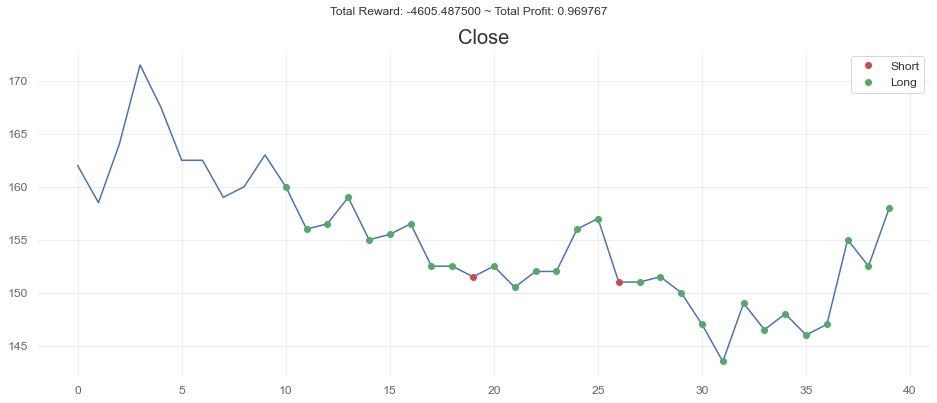

In [19]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


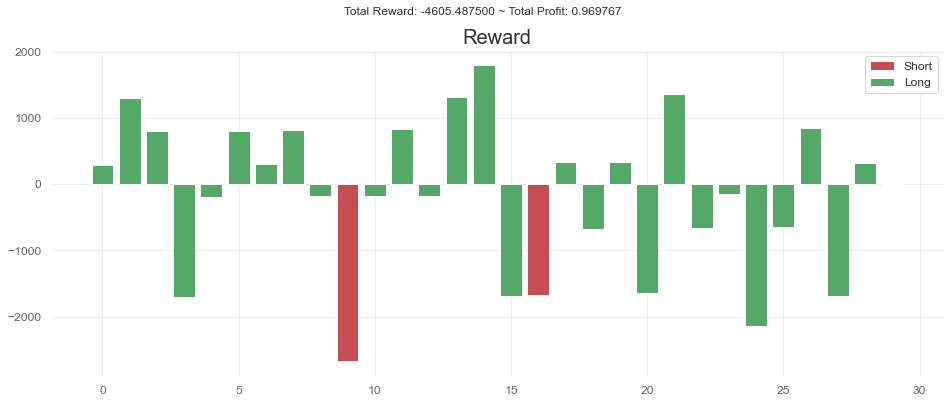

In [20]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


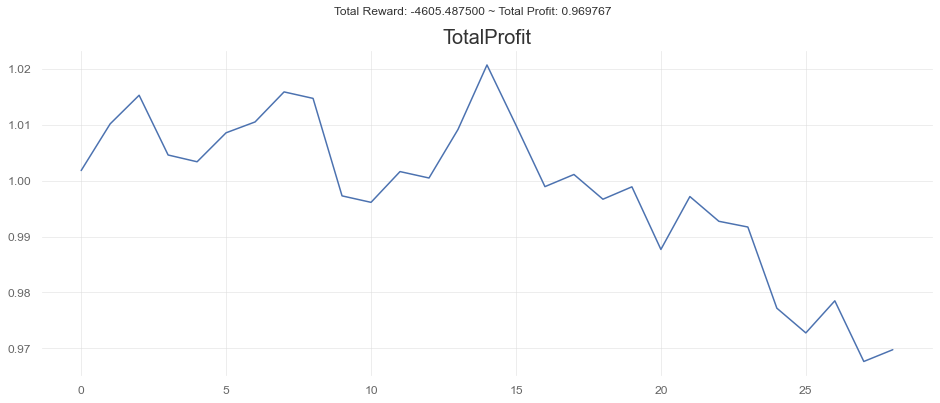

In [21]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)